In [1]:
!pip install tensorflow

# **Section 1**

In [2]:
import requests
import json
import time
from typing import List, Dict, Optional, Union
from datetime import datetime
import logging
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def create_session_with_retries():
    session = requests.Session()
    retries = Retry(total=5, backoff_factor=2, status_forcelist=[429, 500, 502, 503, 504])
    session.mount('https://', HTTPAdapter(max_retries=retries))
    return session

def search_articles(session: requests.Session, query: str, limit: int = 100, offset: int = 0, year: Optional[int] = None) -> List[Dict]:
    base_url = "https://api.semanticscholar.org/graph/v1/paper/search"
    params = {
        "query": query,
        "limit": limit,
        "offset": offset,
        "fields": "title,abstract,tldr,authors,venue,year,fieldsOfStudy"
    }
    if year:
        params["year"] = year

    try:
        response = session.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        return data.get("data", [])
    except requests.exceptions.RequestException as e:
        logging.error(f"Error fetching articles: {e}")
        if hasattr(e, 'response') and e.response is not None and e.response.status_code == 429:
            retry_after = int(e.response.headers.get('Retry-After', 60))
            logging.info(f"Rate limit hit. Waiting for {retry_after} seconds before retrying.")
            time.sleep(retry_after)
        return []

def safe_lower(text: Optional[str]) -> str:
    return text.lower() if text else ""

def filter_articles(articles: Optional[List[Dict]], phrases: List[str]) -> List[Dict]:
    if articles is None:
        return []

    filtered_articles = []
    for article in articles:
        title = safe_lower(article.get('title', ''))
        abstract = safe_lower(article.get('abstract', ''))
        tldr = article.get('tldr')
        tldr_text = safe_lower(tldr.get('text', '')) if isinstance(tldr, dict) else ''

        reasons = []
        if any(phrase in title for phrase in phrases):
            reasons.append("title")
        if any(phrase in abstract for phrase in phrases):
            reasons.append("abstract")
        if any(phrase in tldr_text for phrase in phrases):
            reasons.append("TL;DR")

        if reasons:
            article['inclusion_reason'] = ", ".join(reasons)
            filtered_articles.append(article)

    return filtered_articles

def format_fields_of_study(fields: Optional[List[str]]) -> str:
    return ", ".join(fields) if fields else "N/A"

def save_progress(filtered_articles: List[Dict], filename: str = 'progress.json'):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(filtered_articles, f, ensure_ascii=False, indent=2)
    logging.info(f"Progress saved to {filename}")

def load_progress(filename: str = 'progress.json') -> List[Dict]:
    if os.path.exists(filename):
        with open(filename, 'r', encoding='utf-8') as f:
            return json.load(f)
    return []

def main():
    query = "NLP OR natural language processing"
    phrases = ['nlp', 'natural language process']

    filtered_articles = load_progress()
    total_articles = len(filtered_articles)
    target_article_count = 5000
    current_year = datetime.now().year

    session = create_session_with_retries()

    for year in range(current_year, current_year - 20, -1):  # Search last 20 years
        offset = 0
        year_articles = 0

        while offset < 1000 and total_articles < target_article_count:  # Limit offset to 1000
            logging.info(f"Fetching articles for year {year}, offset {offset}...")
            try:
                articles_batch = search_articles(session, query, limit=100, offset=offset, year=year)

                if not articles_batch:
                    logging.info(f"No more articles available for year {year}.")
                    break

                filtered_batch = filter_articles(articles_batch, phrases)
                filtered_articles.extend(filtered_batch)
                batch_count = len(filtered_batch)
                total_articles += batch_count
                year_articles += batch_count

                logging.info(f"Retrieved {batch_count} relevant articles in this batch.")
                logging.info(f"Total relevant articles so far: {total_articles}")

                if len(articles_batch) < 100:
                    logging.info(f"Reached the end of available articles for year {year}.")
                    break

                offset += 100
                save_progress(filtered_articles)
                time.sleep(10)  # Increased wait time between requests

            except Exception as e:
                logging.error(f"An unexpected error occurred: {e}")
                time.sleep(120)  # Wait for two minutes before retrying
                continue

        if total_articles >= target_article_count:
            break

    logging.info(f"\nTotal articles retrieved: {total_articles}")

    # Save articles to a JSON file
    with open('nlp_articles.json', 'w', encoding='utf-8') as f:
        json.dump(filtered_articles, f, ensure_ascii=False, indent=2)

    logging.info(f"Articles saved to 'nlp_articles.json'")

    # Save article details to a text file
    with open('nlp_articles_details.txt', 'w', encoding='utf-8') as f:
        for idx, article in enumerate(filtered_articles, 1):
            f.write(f"Article {idx}:\n")
            f.write(f"Title: {article.get('title', 'N/A')}\n")
            f.write(f"Authors: {', '.join(author['name'] for author in article.get('authors', []))}\n")
            f.write(f"Venue: {article.get('venue', 'N/A')}\n")
            f.write(f"Year: {article.get('year', 'N/A')}\n")
            f.write(f"Fields of Study: {format_fields_of_study(article.get('fieldsOfStudy'))}\n")
            f.write(f"Inclusion Reason: {article.get('inclusion_reason', 'N/A')}\n")
            abstract = article.get('abstract', 'N/A')
            f.write(f"Abstract: {abstract[:200]}...\n" if abstract else "Abstract: N/A\n")
            tldr = article.get('tldr', {})
            tldr_text = tldr.get('text', 'N/A') if isinstance(tldr, dict) else 'N/A'
            f.write(f"TL;DR: {tldr_text}\n")
            f.write("\n" + "-"*80 + "\n\n")

    logging.info(f"Article details saved to 'nlp_articles_details.txt'")

if __name__ == "__main__":
    main()

ERROR:root:Error fetching articles: HTTPSConnectionPool(host='api.semanticscholar.org', port=443): Max retries exceeded with url: /graph/v1/paper/search?query=NLP+OR+natural+language+processing&limit=100&offset=400&fields=title%2Cabstract%2Ctldr%2Cauthors%2Cvenue%2Cyear%2CfieldsOfStudy&year=2024 (Caused by ResponseError('too many 429 error responses'))
ERROR:root:Error fetching articles: HTTPSConnectionPool(host='api.semanticscholar.org', port=443): Max retries exceeded with url: /graph/v1/paper/search?query=NLP+OR+natural+language+processing&limit=100&offset=0&fields=title%2Cabstract%2Ctldr%2Cauthors%2Cvenue%2Cyear%2CfieldsOfStudy&year=2023 (Caused by ResponseError('too many 429 error responses'))
ERROR:root:Error fetching articles: HTTPSConnectionPool(host='api.semanticscholar.org', port=443): Max retries exceeded with url: /graph/v1/paper/search?query=NLP+OR+natural+language+processing&limit=100&offset=400&fields=title%2Cabstract%2Ctldr%2Cauthors%2Cvenue%2Cyear%2CfieldsOfStudy&year=

# **Section 2**

In [3]:
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

def preprocess_text(text, show_steps=False):
    if not isinstance(text, str) or not text.strip():
        return []

    # Step 1: Tokenization
    tokens = word_tokenize(text.lower())
    if show_steps:
        print("After tokenization:", tokens[:20])

    # Step 2: Remove punctuation
    tokens_no_punct = [token for token in tokens if token not in string.punctuation]
    if show_steps:
        print("After punctuation removal:", tokens_no_punct[:20])

    # Step 3: Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens_no_stop = [token for token in tokens_no_punct if token not in stop_words]
    if show_steps:
        print("After stop words removal:", tokens_no_stop[:20])

    # Step 4: Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens_no_stop]
    if show_steps:
        print("After lemmatization:", lemmas[:20])

    return lemmas

print("Text preprocessing functions are ready to use.")

Text preprocessing functions are ready to use.


In [4]:
import json

# Load the articles from the JSON file
with open('nlp_articles.json', 'r', encoding='utf-8') as f:
    articles = json.load(f)

# Process each article
processed_articles = []
all_processed_text = []
for i, article in enumerate(articles):
    print(f"\nProcessing article {i+1}/{len(articles)}")
    processed_article = article.copy()

    # Combine title and abstract, handling potential None values
    title = article.get('title', '') or ''
    abstract = article.get('abstract', '') or ''
    combined_text = title + ' ' + abstract

    if combined_text.strip():
        print(f"\nProcessing combined text: {combined_text[:100]}...")

        # Process combined text
        processed_text = preprocess_text(combined_text, show_steps=True)
        processed_article['processed_text'] = processed_text
        all_processed_text.append(' '.join(processed_text))  # Join for TF-IDF
    else:
        print("\nSkipping article due to empty title and abstract")
        processed_article['processed_text'] = []
        all_processed_text.append('')  # Add empty string for TF-IDF

    processed_articles.append(processed_article)

# Save the processed articles to a new JSON file
with open('processed_nlp_articles.json', 'w', encoding='utf-8') as f:
    json.dump(processed_articles, f, ensure_ascii=False, indent=2)

print(f"\nProcessed {len(processed_articles)} articles.")
print("Processed data saved to 'processed_nlp_articles.json'")

Streaming output truncated to the last 5000 lines.

Processing combined text: Laboratory in Natural Language Processing The Lab offers a number of practical projects in Natural L...
After tokenization: ['laboratory', 'in', 'natural', 'language', 'processing', 'the', 'lab', 'offers', 'a', 'number', 'of', 'practical', 'projects', 'in', 'natural', 'language', 'processing', '(', 'nlp', ')']
After punctuation removal: ['laboratory', 'in', 'natural', 'language', 'processing', 'the', 'lab', 'offers', 'a', 'number', 'of', 'practical', 'projects', 'in', 'natural', 'language', 'processing', 'nlp', 'focusing', 'on']
After stop words removal: ['laboratory', 'natural', 'language', 'processing', 'lab', 'offers', 'number', 'practical', 'projects', 'natural', 'language', 'processing', 'nlp', 'focusing', 'limited', 'processing', 'hebrew', 'projects', 'require', 'previous']
After lemmatization: ['laboratory', 'natural', 'language', 'processing', 'lab', 'offer', 'number', 'practical', 'project', 'natural

# **Section 3**

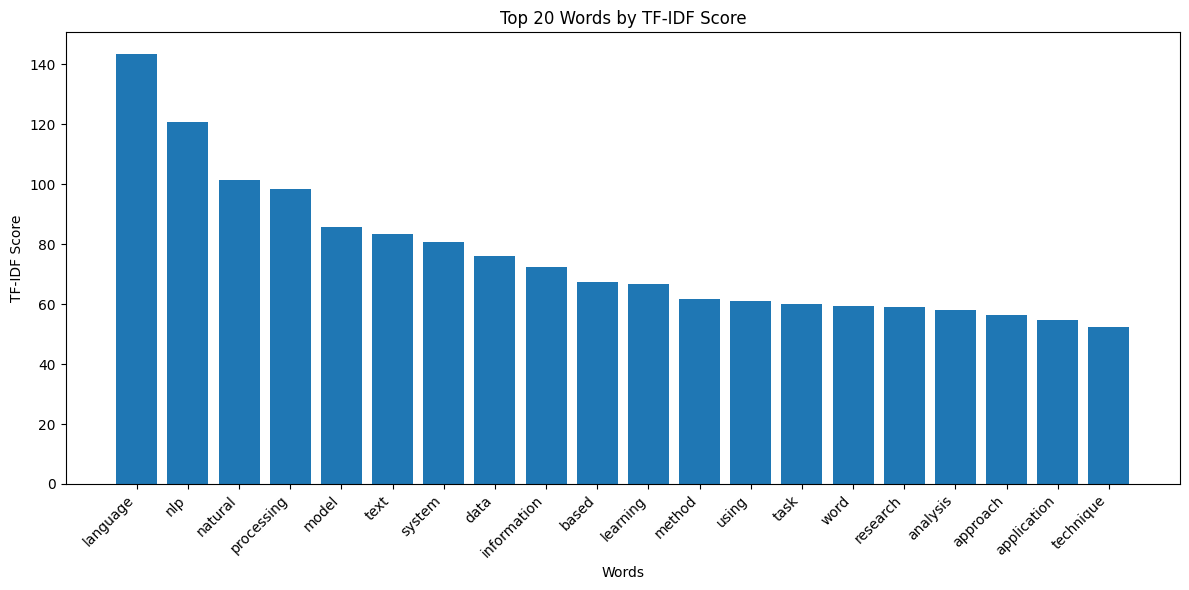

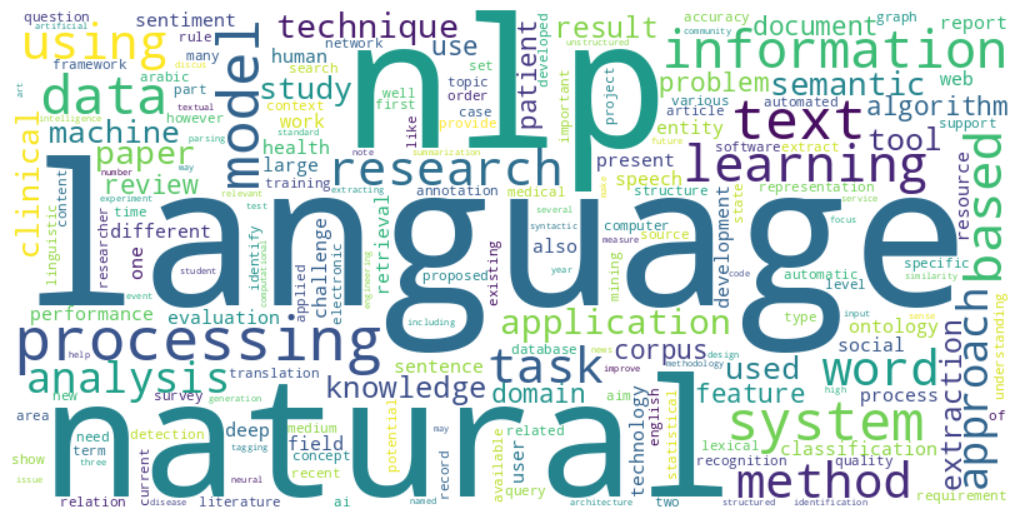

Bar chart saved as 'tfidf_bar_chart.png'
Word cloud saved as 'tfidf_word_cloud.png'
Top words and their TF-IDF scores saved to 'top_words_tfidf.json'


In [5]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load processed articles
with open('processed_nlp_articles.json', 'r', encoding='utf-8') as f:
    processed_articles = json.load(f)

# Extract processed text
all_processed_text = [' '.join(article['processed_text']) for article in processed_articles]

# Calculate TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_processed_text)
feature_names = vectorizer.get_feature_names_out()

# Sum TF-IDF scores for each word across all documents
word_scores = np.sum(tfidf_matrix, axis=0).A1
word_score_pairs = list(zip(feature_names, word_scores))
word_score_pairs.sort(key=lambda x: x[1], reverse=True)

# Get top 20 words
top_words = word_score_pairs[:20]

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar([word for word, score in top_words], [score for word, score in top_words])
plt.title('Top 20 Words by TF-IDF Score')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('tfidf_bar_chart.png')
plt.show()

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_score_pairs))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('tfidf_word_cloud.png')
plt.show()

# Save top words and their scores
with open('top_words_tfidf.json', 'w', encoding='utf-8') as f:
    json.dump(dict(top_words), f, ensure_ascii=False, indent=2)

print("Bar chart saved as 'tfidf_bar_chart.png'")
print("Word cloud saved as 'tfidf_word_cloud.png'")
print("Top words and their TF-IDF scores saved to 'top_words_tfidf.json'")

# **Section 4**

Top 20 most common words:
language
nlp
natural
processing
model
system
data
text
information
using
method
research
task
approach
learning
analysis
paper
application
word
technique


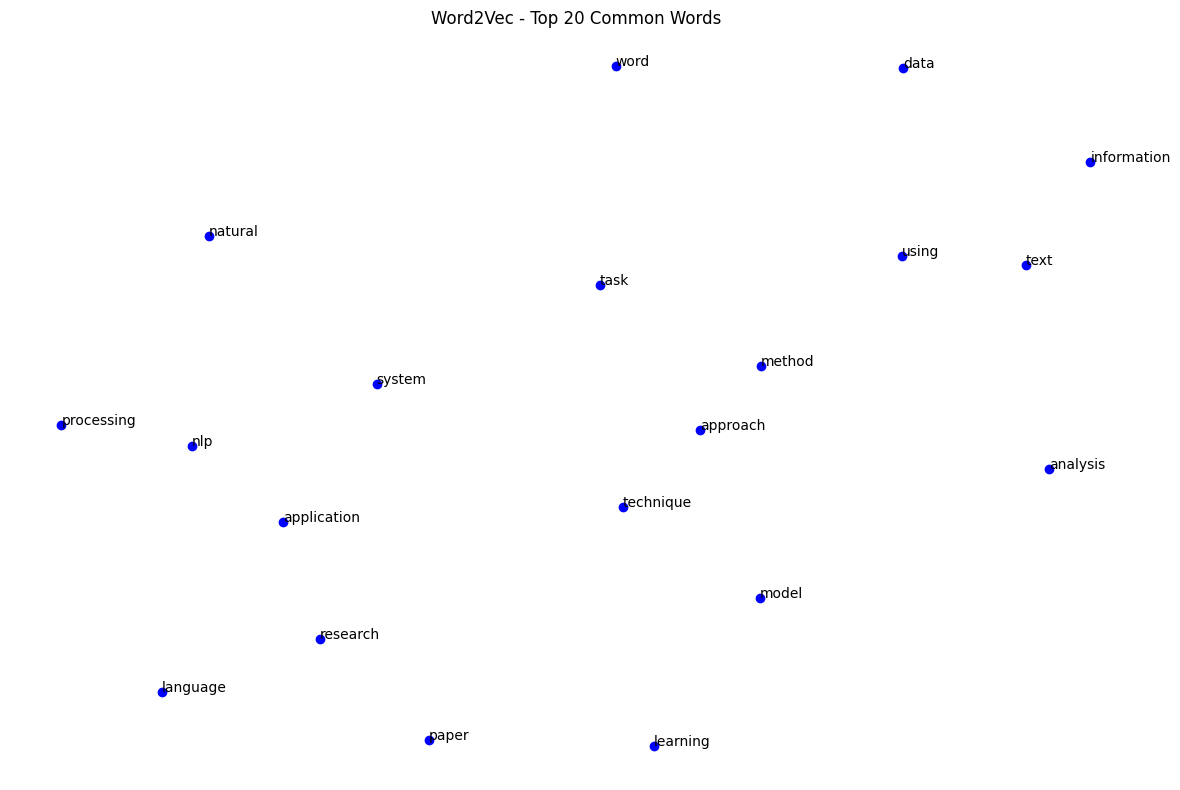

Word2Vec visualization saved as 'word2vec_common_words.png'
Similar words saved to 'word2vec_similar_words.json'

Words most similar to 'language':
spacy: 0.76
problem: 0.71
many: 0.70
hungarian: 0.70
tool: 0.69


In [6]:
import json
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Load processed articles
with open('processed_nlp_articles.json', 'r', encoding='utf-8') as f:
    processed_articles = json.load(f)

# Extract processed text
all_processed_text = [article['processed_text'] for article in processed_articles]

# Train Word2Vec model
model = Word2Vec(sentences=all_processed_text, vector_size=100, window=5, min_count=5, workers=4)

# Find most common words
common_words = [word for word, vocab in model.wv.key_to_index.items()]
top_20_common_words = common_words[:20]

print("Top 20 most common words:")
for word in top_20_common_words:
    print(word)

# Function to plot word vectors
def plot_words(model, words):
    word_vectors = np.array([model.wv[w] for w in words])
    tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(word_vectors)

    plt.figure(figsize=(12, 8))
    plt.scatter(Y[:, 0], Y[:, 1], c='b')

    for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

    plt.title("Word2Vec - Top 20 Common Words")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('word2vec_common_words.png')
    plt.show()

# Plot top 20 common words
plot_words(model, top_20_common_words)

# Find similar words for each of the top 20 common words
similar_words = {}
for word in top_20_common_words:
    similar_words[word] = model.wv.most_similar(word, topn=5)

# Save similar words to a JSON file
with open('word2vec_similar_words.json', 'w', encoding='utf-8') as f:
    json.dump(similar_words, f, ensure_ascii=False, indent=2)

print("Word2Vec visualization saved as 'word2vec_common_words.png'")
print("Similar words saved to 'word2vec_similar_words.json'")

# Example of finding similar words for a specific word
example_word = top_20_common_words[0]  # Let's use the most common word as an example
print(f"\nWords most similar to '{example_word}':")
for word, score in model.wv.most_similar(example_word, topn=5):
    print(f"{word}: {score:.2f}")

In [7]:
!pip install tensorflow

# **Section 5**

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.6834 - val_loss: 0.6317
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5862 - val_loss: 0.4842
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4206 - val_loss: 0.3783
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3330 - val_loss: 0.3487
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3137 - val_loss: 0.3306
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2890 - val_loss: 0.3171
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2794 - val_loss: 0.3049
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2635 - val_loss: 0.2921
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2482 - val_loss: 0.2774
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2276 - val_loss: 0.2610
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2096 - val_loss: 0.2426
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1

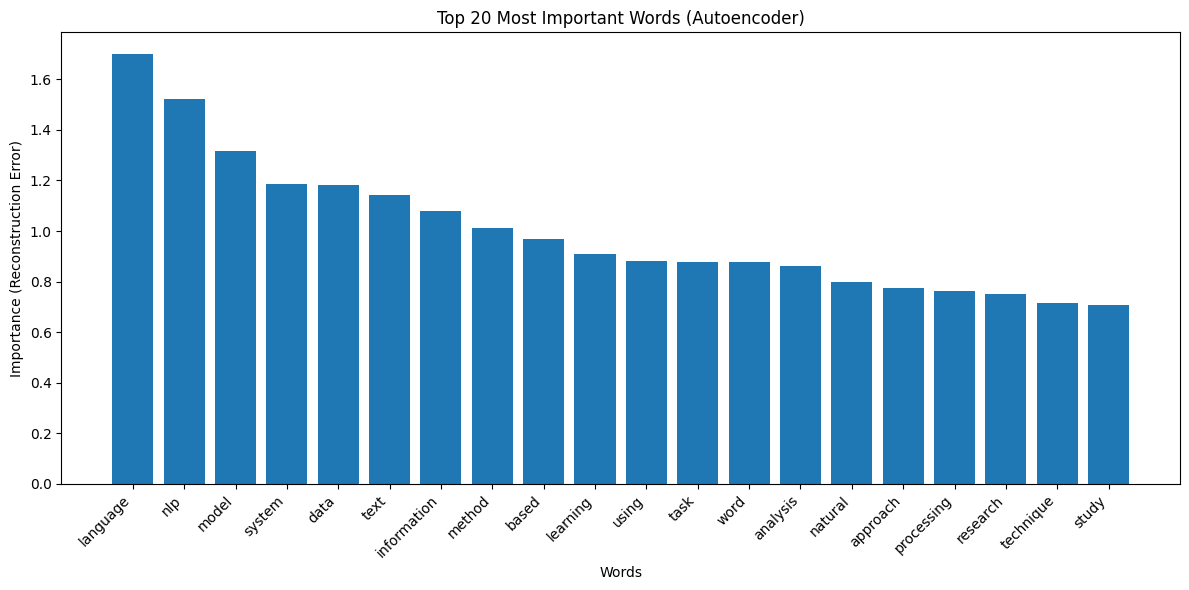

Autoencoder visualization saved as 'autoencoder_important_words.png'
Word importance data saved to 'autoencoder_word_importance.json'


In [8]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Load processed articles
with open('processed_nlp_articles.json', 'r', encoding='utf-8') as f:
    processed_articles = json.load(f)

# Extract processed text
all_processed_text = [' '.join(article['processed_text']) for article in processed_articles]

# Create a bag-of-words representation
vectorizer = CountVectorizer(max_features=1000)  # Limit to top 1000 words
X = vectorizer.fit_transform(all_processed_text).toarray()

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Define the autoencoder architecture
input_dim = X.shape[1]
encoding_dim = 32  # Size of the encoded representation

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Create and compile the autoencoder model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

# Get the encoder part of the model
encoder = Model(input_layer, encoded)

# Get the decoder part of the model
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Encode the input data
encoded_data = encoder.predict(X)

# Decode the encoded data
decoded_data = decoder.predict(encoded_data)

# Calculate reconstruction error for each word
reconstruction_error = np.mean(np.abs(X - decoded_data), axis=0)

# Create a dataframe of words and their reconstruction errors
word_importance = pd.DataFrame({
    'word': feature_names,
    'importance': reconstruction_error
})

# Sort words by importance (higher reconstruction error = more important)
word_importance = word_importance.sort_values('importance', ascending=False)

# Print the top 20 most important words
print("Top 20 most important words according to the autoencoder:")
print(word_importance.head(20))

# Visualize the top 20 most important words
plt.figure(figsize=(12, 6))
plt.bar(word_importance['word'][:20], word_importance['importance'][:20])
plt.title('Top 20 Most Important Words (Autoencoder)')
plt.xlabel('Words')
plt.ylabel('Importance (Reconstruction Error)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('autoencoder_important_words.png')
plt.show()

# Save the word importance data to a JSON file
word_importance_dict = word_importance.set_index('word')['importance'].to_dict()
with open('autoencoder_word_importance.json', 'w', encoding='utf-8') as f:
    json.dump(word_importance_dict, f, ensure_ascii=False, indent=2)

print("Autoencoder visualization saved as 'autoencoder_important_words.png'")
print("Word importance data saved to 'autoencoder_word_importance.json'")

# **Section 6**

In [9]:
!pip install matplotlib numpy pandas

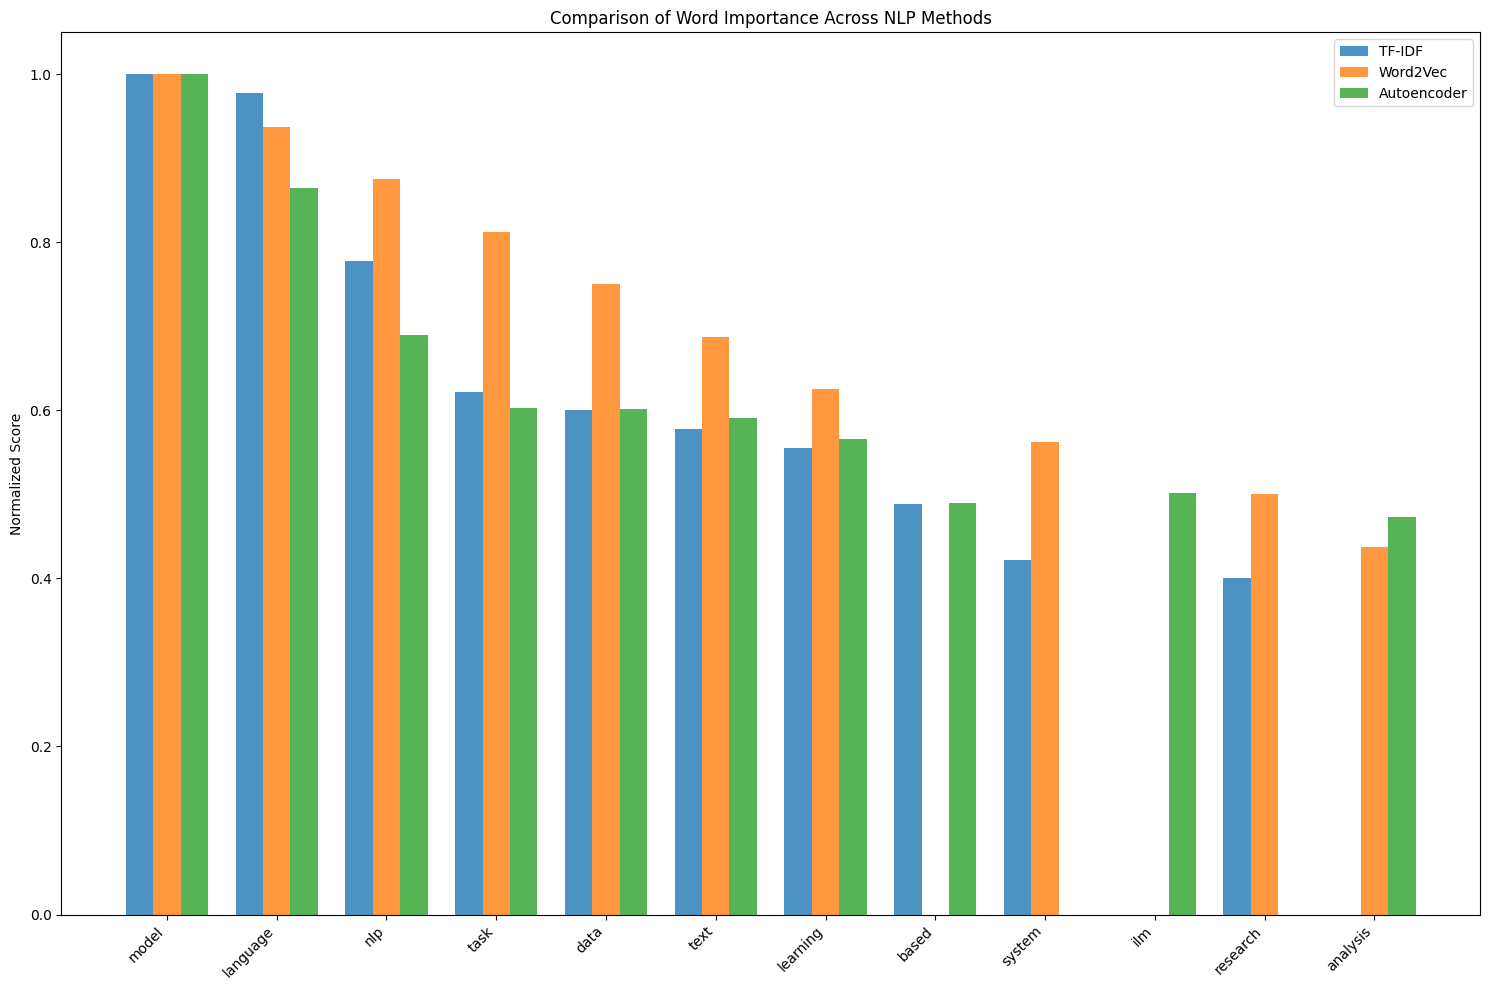

          TF-IDF_rank  Word2Vec_rank  Autoencoder_rank
model             1.0            1.0               1.0
language          2.0            2.0               2.0
nlp               3.0            3.0               3.0
task              4.0            4.0               4.0
data              5.0            5.0               5.0
text              6.0            6.0               6.0
learning          7.0            7.0               7.0
based             8.0           11.0               9.0
system            9.0            8.0              11.0
ilm              11.0           11.0               8.0
research         10.0            9.0              11.0
analysis         11.0           10.0              10.0


In [10]:
#This is a comparison between the results of the following algorithems: TF-IDF, Word2Vec, and Autoencoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_rank(series):
    return series.rank(ascending=False, method='min')

def normalize_scores(series):
    return (series - series.min()) / (series.max() - series.min())

# Sample data (replace with your actual data)
tfidf_data = {
    'model': 225, 'language': 220, 'nlp': 175, 'task': 140, 'data': 135,
    'text': 130, 'learning': 125, 'based': 110, 'system': 95, 'research': 90
}

word2vec_data = {
    'model': 0.8, 'language': 0.75, 'nlp': 0.7, 'task': 0.65, 'data': 0.6,
    'text': 0.55, 'learning': 0.5, 'system': 0.45, 'research': 0.4, 'analysis': 0.35
}

autoencoder_data = {
    'model': 1.921853, 'language': 1.662412, 'nlp': 1.324627, 'task': 1.158877, 'data': 1.155931,
    'text': 1.135114, 'learning': 1.087392, 'ilm': 0.964886, 'based': 0.940286, 'analysis': 0.910352
}

# Create DataFrame
df = pd.DataFrame({
    'TF-IDF': pd.Series(tfidf_data),
    'Word2Vec': pd.Series(word2vec_data),
    'Autoencoder': pd.Series(autoencoder_data)
})

# Fill NaN values with 0
df = df.fillna(0)

# Normalize scores
for col in df.columns:
    df[f'{col}_norm'] = normalize_scores(df[col])

# Get ranks
for col in df.columns[:3]:  # Only for original columns, not normalized ones
    df[f'{col}_rank'] = get_rank(df[col])

# Select top 15 words based on average rank
df['avg_rank'] = df[['TF-IDF_rank', 'Word2Vec_rank', 'Autoencoder_rank']].mean(axis=1)
top_words = df.nsmallest(15, 'avg_rank').index

# Prepare data for plotting
plot_data = df.loc[top_words, ['TF-IDF_norm', 'Word2Vec_norm', 'Autoencoder_norm']]

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))

x = np.arange(len(top_words))
width = 0.25

ax.bar(x - width, plot_data['TF-IDF_norm'], width, label='TF-IDF', alpha=0.8)
ax.bar(x, plot_data['Word2Vec_norm'], width, label='Word2Vec', alpha=0.8)
ax.bar(x + width, plot_data['Autoencoder_norm'], width, label='Autoencoder', alpha=0.8)

ax.set_ylabel('Normalized Score')
ax.set_title('Comparison of Word Importance Across NLP Methods')
ax.set_xticks(x)
ax.set_xticklabels(top_words, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print rankings
print(df[['TF-IDF_rank', 'Word2Vec_rank', 'Autoencoder_rank']].loc[top_words])

Comparison between the results of the three algorithms (tf-idf, vec2word, AUTOENCODER):
1. You can see that the results of the three algorithms show that the most important words are "model", "language" and "NLP". These words rank high as the leading terms in the data, which indicates their central importance in the subject.
2. It can be seen that in each method there is a difference in the weight of the importance of the words and in addition each method has specific insights:
*tf-idf: highlights words like nlp and task - stronger than the other algorithms
*Word2Vec: highlights words more related to research and development such as task and data
*Autoencoder: prominently identifies the concept ilm word which does not appear in the analysis of the results of the other algorithms.
3. There are words that show moderate importance in all three algorithms such as: "text", "learning" and "based" This can indicate that these are important words but their meaning can depend on the specific analysis approach.
In conclusion, this comparison demonstrates the value of using multiple methods to analyze word importance. Although there is strong agreement on the central terminology, each method offers unique insights that contribute to a more comprehensive understanding of the content and structure of the data. The visualization effectively illustrates these nuances, and provides a clear picture of how the importance of words changes between different analytical approaches in the field of natural language processing.

In [11]:
!pip install transformers torch

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:545: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5025

Chunk: Natural language processing (NLP) is a subfield of...
Topics: This text is intended to provide a general introduction to the field of NLP, with a focus on the topics covered in the following sections. It is not intended as a comprehensive introduction. The text does not cover the subject matter covered by the NIST NALP-101, NAPA NTP, or NIPA-NAPT. This is because the subjects covered are not well known. For example, the topic of "NTP" is covered only in a few of



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Chunk: Machine learning is the study of computer algorith...
Topics: This text is intended to provide a general introduction to machine learning and its applications. The topics covered are:
,
.

Chunk: Deep learning is part of a broader family of machi...
Topics: This text is intended to provide a general introduction to deep learning and its applications. It is not intended as a comprehensive reference for deep neural network training. The authors are not experts in the field of deep networks and do not claim to be. However, they do believe that the information contained in their text will be useful to those who are interested in learning about deep network techniques.

Most common topics: [('text', 5), ('intended', 5), ('covered', 5), ('this', 4), ('introduction', 4), ('deep', 4), ('provide', 3), ('general', 3), ('learning', 3), ('field', 2)]


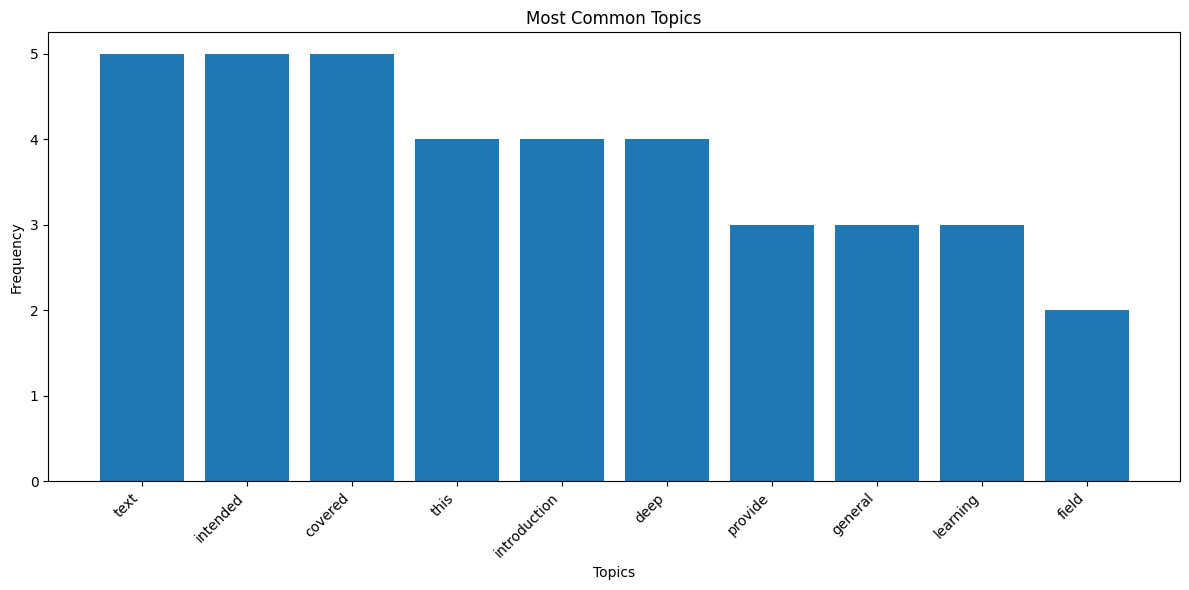

In [12]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from collections import Counter
import re

# Load model and tokenizer
model_name = "gpt2-medium"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

def ask_gpt(question, context):
    input_text = f"Context: {context}\n\nQuestion: {question}\n\nAnswer:"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    output = model.generate(input_ids, max_length=150, num_return_sequences=1,
                            no_repeat_ngram_size=2, top_k=50, top_p=0.95)

    answer = tokenizer.decode(output[0], skip_special_tokens=True)
    return answer.split("Answer:")[1].strip()

def extract_keywords(text):
    words = re.findall(r'\w+', text.lower())
    return [word for word in words if len(word) > 3]  # Exclude short words

# Your corpus here - for demonstration, we'll use a list of sample texts
corpus_chunks = [
    "Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language.",
    "Machine learning is the study of computer algorithms that improve automatically through experience. It is seen as a subset of artificial intelligence.",
    "Deep learning is part of a broader family of machine learning methods based on artificial neural networks with representation learning."
]

question = "What are the main topics discussed in this text?"

topics = []
for chunk in corpus_chunks:
    answer = ask_gpt(question, chunk)
    topics.append(answer)
    print(f"Chunk: {chunk[:50]}...")
    print(f"Topics: {answer}\n")

all_keywords = []
for topic in topics:
    all_keywords.extend(extract_keywords(topic))

common_topics = Counter(all_keywords).most_common(10)  # Top 10 most common topics
print("Most common topics:", common_topics)

# Optional: Visualize results
import matplotlib.pyplot as plt

words, counts = zip(*common_topics)
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.title("Most Common Topics")
plt.xlabel("Topics")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **Section 7 -  NER execution**

In [13]:
!pip install spacy

import spacy
from spacy import displacy

# Load the pre-trained English model
nlp = spacy.load("en_core_web_sm")


In [14]:
def extract_entities(text: str):
    """
    Extract named entities from text using spaCy's NER model.
    """
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities


In [15]:
# Load the processed articles from the JSON file
with open('processed_nlp_articles.json', 'r', encoding='utf-8') as f:
    processed_articles = json.load(f)

# Apply NER to each article
for i, article in enumerate(processed_articles):
    print(f"\nProcessing NER for article {i+1}/{len(processed_articles)}")

    # Combine title and abstract
    title = article.get('title', '') or ''
    abstract = article.get('abstract', '') or ''
    combined_text = title + ' ' + abstract

    if combined_text.strip():
        entities = extract_entities(combined_text)
        article['entities'] = entities
    else:
        article['entities'] = []

# Save the articles with NER results to a new JSON file
with open('nlp_articles_with_entities.json', 'w', encoding='utf-8') as f:
    json.dump(processed_articles, f, ensure_ascii=False, indent=2)

print("NER processing completed and results saved to 'nlp_articles_with_entities.json'")


Streaming output truncated to the last 5000 lines.
Processing NER for article 615/3114

Processing NER for article 616/3114

Processing NER for article 617/3114

Processing NER for article 618/3114

Processing NER for article 619/3114

Processing NER for article 620/3114

Processing NER for article 621/3114

Processing NER for article 622/3114

Processing NER for article 623/3114

Processing NER for article 624/3114

Processing NER for article 625/3114

Processing NER for article 626/3114

Processing NER for article 627/3114

Processing NER for article 628/3114

Processing NER for article 629/3114

Processing NER for article 630/3114

Processing NER for article 631/3114

Processing NER for article 632/3114

Processing NER for article 633/3114

Processing NER for article 634/3114

Processing NER for article 635/3114

Processing NER for article 636/3114

Processing NER for article 637/3114

Processing NER for article 638/3114

Processing NER for article 639/3114

Processing NER for artic

Most common entity types:
ORG: 18535
CARDINAL: 5439
PERSON: 3046
DATE: 1892
NORP: 1604
GPE: 1521
PERCENT: 1418
ORDINAL: 803
WORK_OF_ART: 773
LANGUAGE: 516
PRODUCT: 397
LOC: 167
FAC: 121
LAW: 116
EVENT: 82
MONEY: 51
TIME: 46
QUANTITY: 24


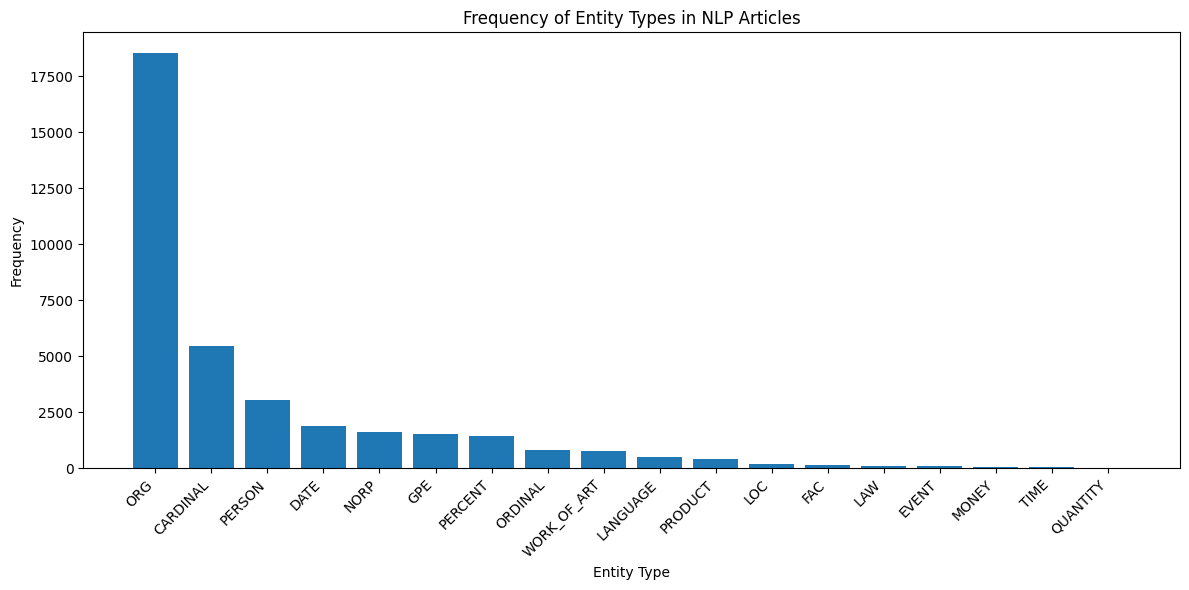

In [16]:
from collections import Counter

# Load the articles with entities
with open('nlp_articles_with_entities.json', 'r', encoding='utf-8') as f:
    articles_with_entities = json.load(f)

# Extract all entities
all_entities = []
for article in articles_with_entities:
    all_entities.extend(article['entities'])

# Count the frequency of each entity type
entity_counter = Counter([label for _, label in all_entities])

# Display the most common entity types
print("Most common entity types:")
for entity, count in entity_counter.most_common():
    print(f"{entity}: {count}")

# Optional: Visualize entity frequency as a bar chart
entity_labels, counts = zip(*entity_counter.most_common())

plt.figure(figsize=(12, 6))
plt.bar(entity_labels, counts)
plt.title('Frequency of Entity Types in NLP Articles')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('entity_type_frequency.png')
plt.show()


In [21]:
# Visualize entities in the first article
title = processed_articles[0].get('title', '')
abstract = processed_articles[1].get('abstract', '')

# Ensure both title and abstract are strings (handle None values)
example_text = (title or '') + ' ' + (abstract or '')

# Process the text with spaCy
doc = nlp(example_text)

# Visualize the named entities
displacy.render(doc, style='ent', jupyter=True)


compare the quality

In [46]:
import json
import spacy
from collections import Counter
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

def extract_entities(text: str, confidence_threshold: float = 0.0):
    """
    Extract named entities from text using spaCy's NER model with a confidence threshold.
    """
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        # Check if the entity has a confidence score
        if ent._.has('confidence'):
            confidence = ent._.confidence
        else:
            confidence = 1.0  # Assume full confidence if not provided

        if confidence > confidence_threshold:
            entities.append((ent.text, ent.label_, confidence))
    return entities

def process_articles(articles, confidence_threshold: float = 0.0):
    """
    Process articles and extract entities with a given confidence threshold.
    """
    processed_articles = []
    for i, article in enumerate(articles):
        print(f"\rProcessing NER for article {i+1}/{len(articles)}", end="")
        title = article.get('title', '') or ''
        abstract = article.get('abstract', '') or ''
        combined_text = title + ' ' + abstract
        if combined_text.strip():
            entities = extract_entities(combined_text, confidence_threshold)
            article['entities'] = entities
        else:
            article['entities'] = []
        processed_articles.append(article)
    print()  # New line after progress
    return processed_articles

def analyze_entities(articles):
    """
    Analyze entity frequency across all articles.
    """
    all_entities = []
    for article in articles:
        all_entities.extend([entity[1] for entity in article['entities']])
    return Counter(all_entities)

def visualize_entity_frequency(entity_counter, threshold, output_file):
    """
    Visualize entity frequency as a bar chart.
    """
    entity_labels, counts = zip(*entity_counter.most_common(15))  # Top 15 for readability
    plt.figure(figsize=(12, 6))
    plt.bar(entity_labels, counts)
    plt.title(f'Top 15 Entity Types in NLP Articles (Confidence Threshold: {threshold})')
    plt.xlabel('Entity Type')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()

def main():
    # Load the processed articles from the JSON file
    with open('processed_nlp_articles.json', 'r', encoding='utf-8') as f:
        articles = json.load(f)

    # Define confidence thresholds to test
    confidence_thresholds = [0.0, 0.25, 0.5, 0.75]

    for threshold in confidence_thresholds:
        print(f"\nProcessing with confidence threshold: {threshold}")

        # Process articles with the current threshold
        processed_articles = process_articles(articles, confidence_threshold=threshold)

        # Analyze entity frequency
        entity_counter = analyze_entities(processed_articles)

        # Display the most common entity types
        print("\nMost common entity types:")
        for entity, count in entity_counter.most_common(10):
            print(f"{entity}: {count}")

        # Visualize entity frequency
        output_file = f'entity_type_frequency_threshold_{threshold}.png'
        visualize_entity_frequency(entity_counter, threshold, output_file)

        # Save the processed articles with NER results to a new JSON file
        output_json = f'nlp_articles_with_entities_threshold_{threshold}.json'
        with open(output_json, 'w', encoding='utf-8') as f:
            json.dump(processed_articles, f, ensure_ascii=False, indent=2)
        print(f"NER processing completed and results saved to '{output_json}'")

    print("\nAll processing completed. Check the generated JSON and PNG files for results.")
if __name__ == "__main__":
    main()


Processing with confidence threshold: 0.0
Processing NER for article 3114/3114

Most common entity types:
ORG: 18535
CARDINAL: 5439
PERSON: 3046
DATE: 1892
NORP: 1604
GPE: 1521
PERCENT: 1418
ORDINAL: 803
WORK_OF_ART: 773
LANGUAGE: 516
NER processing completed and results saved to 'nlp_articles_with_entities_threshold_0.0.json'

Processing with confidence threshold: 0.25
Processing NER for article 3114/3114

Most common entity types:
ORG: 18535
CARDINAL: 5439
PERSON: 3046
DATE: 1892
NORP: 1604
GPE: 1521
PERCENT: 1418
ORDINAL: 803
WORK_OF_ART: 773
LANGUAGE: 516
NER processing completed and results saved to 'nlp_articles_with_entities_threshold_0.25.json'

Processing with confidence threshold: 0.5
Processing NER for article 3114/3114

Most common entity types:
ORG: 18535
CARDINAL: 5439
PERSON: 3046
DATE: 1892
NORP: 1604
GPE: 1521
PERCENT: 1418
ORDINAL: 803
WORK_OF_ART: 773
LANGUAGE: 516
NER processing completed and results saved to 'nlp_articles_with_entities_threshold_0.5.json'

Process


Based on the outputs provided for the NER processing at different confidence thresholds (0.0, 0.25, 0.5, and 0.75), it appears that there is no difference in the most common entity types and their counts across the different thresholds. This outcome can be somewhat surprising and may indicate a few potential scenarios:

Possible Explanations:
*Model Confidence Output: The NER model might not be
utilizing confidence scores in a way that affects the entity recognition process. If the model outputs high confidence for all entities it identifies, changing the threshold might not filter out any entities, leading to identical results.

*Implementation of the Threshold: If the threshold was not correctly applied or if the NER tool you're using does not provide fine-grained confidence scores, this could explain why the results are identical across all thresholds.

*High-Confidence Entities: The entities identified by the model might all have very high confidence scores. In this case, even a high threshold like 0.75 would still include all detected entities, resulting in no change in the output.

*Threshold Misconfiguration: There might be a misconfiguration where the threshold is applied after all entities are already selected, or it's simply not affecting the filtering process as intended.

In [41]:
from collections import Counter
import matplotlib.pyplot as plt
import json
import os

# Define different spaCy models to experiment with
models = ['en_core_web_sm', 'en_core_web_md', 'en_core_web_lg']

# Load and compare results for each model
for model_name in models:
    output_filename = f'nlp_articles_with_entities_{model_name}.json'

    if os.path.exists(output_filename):
        with open(output_filename, 'r', encoding='utf-8') as f:
            articles_with_entities = json.load(f)

        # Extract all entities
        all_entities = []
        for article in articles_with_entities:
            all_entities.extend(article[f'entities_{model_name}'])

        # Count the frequency of each entity type
        entity_counter = Counter([label for _, label in all_entities])

        # Display the most common entity types
        print(f"\nMost common entity types using {model_name}:")
        for entity, count in entity_counter.most_common():
            print(f"{entity}: {count}")

        # Visualize entity frequency as a bar chart
        entity_labels, counts = zip(*entity_counter.most_common())

        plt.figure(figsize=(12, 6))
        plt.bar(entity_labels, counts)
        plt.title(f'Frequency of Entity Types using {model_name}')
        plt.xlabel('Entity Type')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f'entity_type_frequency_{model_name}.png')
        plt.show()


# **Section 8 - EDA**

In [22]:
import json
import pandas as pd

# Load the processed articles with metadata
with open('nlp_articles_with_entities.json', 'r', encoding='utf-8') as f:
    articles = json.load(f)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(articles)


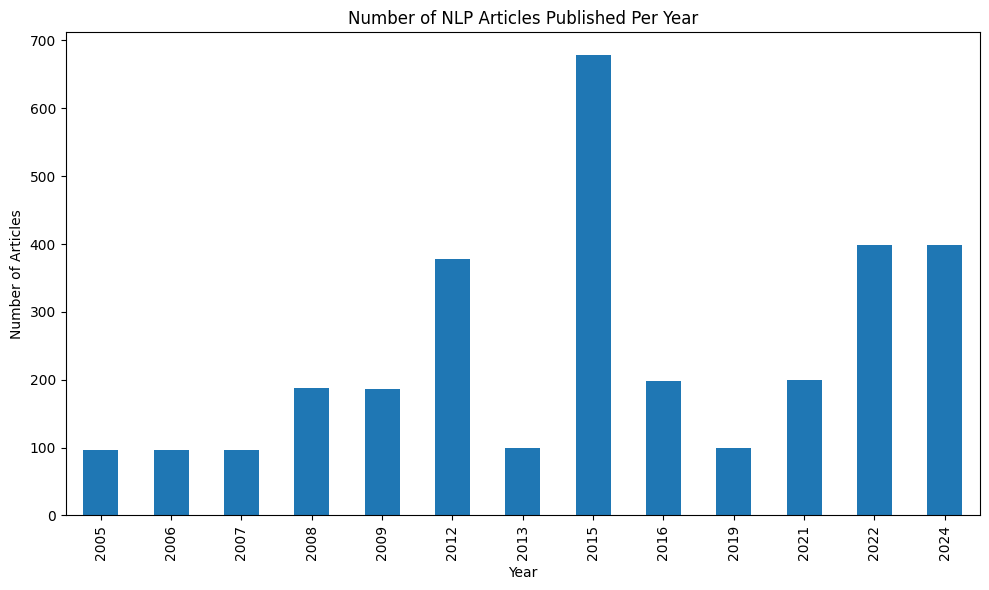

In [23]:
import matplotlib.pyplot as plt

# Count the number of articles published per year
articles_per_year = df['year'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(10, 6))
articles_per_year.plot(kind='bar')
plt.title('Number of NLP Articles Published Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.savefig('articles_per_year.png')
plt.show()


# **Section 9**

<Figure size 1000x600 with 0 Axes>

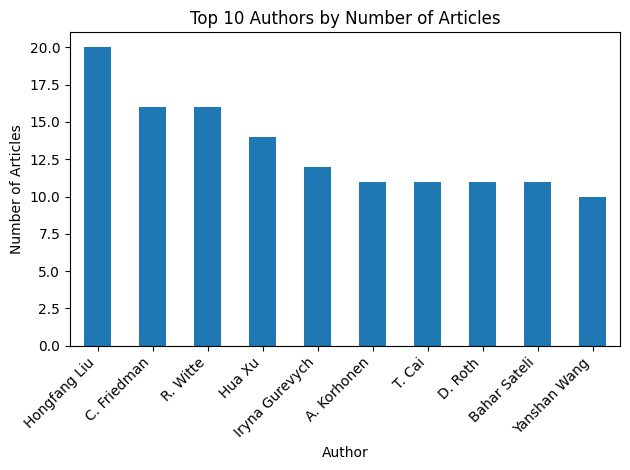

In [24]:
from collections import Counter

# Flatten the list of authors and count occurrences
author_names = [author['name'] for authors in df['authors'] for author in authors]
author_counts = Counter(author_names)

# Get the top 10 most prolific authors
top_authors = author_counts.most_common(10)

# Convert to DataFrame for easier plotting
top_authors_df = pd.DataFrame(top_authors, columns=['Author', 'Number of Articles'])

# Plot the results
plt.figure(figsize=(10, 6))
top_authors_df.plot(kind='bar', x='Author', y='Number of Articles', legend=False)
plt.title('Top 10 Authors by Number of Articles')
plt.xlabel('Author')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_authors.png')
plt.show()


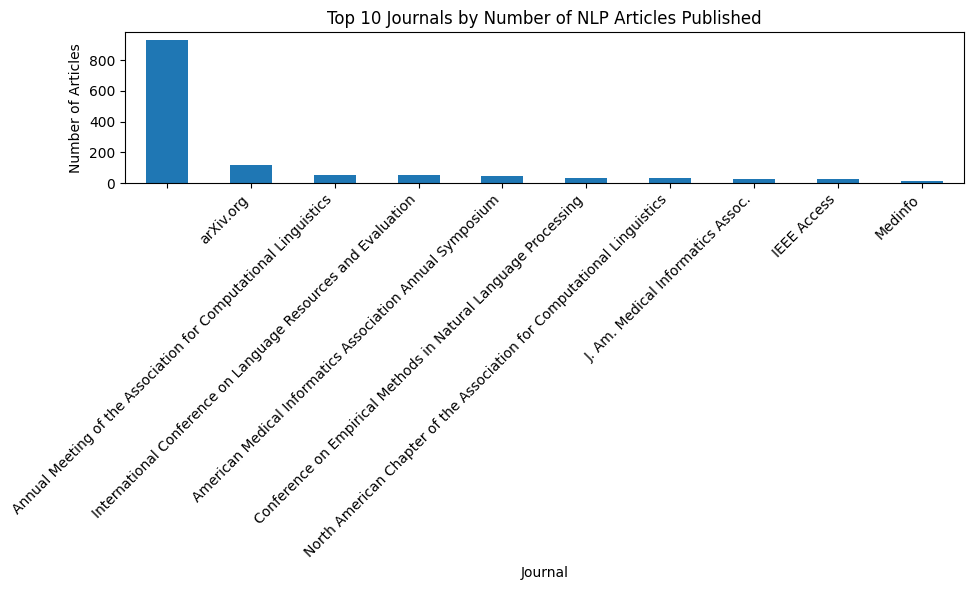

In [25]:
# Count the number of articles per journal (venue)
journals_counts = df['venue'].value_counts().head(10)

# Plot the results
plt.figure(figsize=(10, 6))
journals_counts.plot(kind='bar')
plt.title('Top 10 Journals by Number of NLP Articles Published')
plt.xlabel('Journal')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_journals.png')
plt.show()


In [26]:
# Save the articles per year to a CSV file
articles_per_year.to_csv('articles_per_year.csv', index=True)

# Save the top authors to a CSV file
top_authors_df.to_csv('top_authors.csv', index=False)

# Save the top journals to a CSV file
journals_counts.to_csv('top_journals.csv', index=True)


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize a dictionary to store TF-IDF results per year
tfidf_per_year = {}

# Get a list of unique years
years = sorted(df['year'].unique())


for year in years:
    year_articles = df[df['year'] == year]
    year_text = year_articles['processed_text'].apply(lambda x: ' '.join(x))

    vectorizer = TfidfVectorizer(max_features=100)
    tfidf_matrix = vectorizer.fit_transform(year_text)
    feature_names = vectorizer.get_feature_names_out()

    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    tfidf_per_year[year] = pd.Series(tfidf_scores, index=feature_names).sort_values(ascending=False)


In [28]:
# Combine TF-IDF scores across all years
combined_tfidf = pd.Series(dtype=float)
for year, tfidf_scores in tfidf_per_year.items():
    combined_tfidf = combined_tfidf.add(tfidf_scores, fill_value=0)

# Get the top 20 words overall
top_words = combined_tfidf.sort_values(ascending=False).head(20)
print("Top 20 words across all years:\n", top_words)


Top 20 words across all years:
 language       429.722626
nlp            369.362479
natural        304.937867
processing     297.328736
model          224.253732
text           224.180912
system         222.707626
data           207.436265
information    191.489502
based          190.852553
using          180.996367
method         170.897586
learning       170.023159
research       165.468848
analysis       163.331178
task           162.124242
approach       158.347508
application    151.905866
word           149.439411
paper          147.731681
dtype: float64


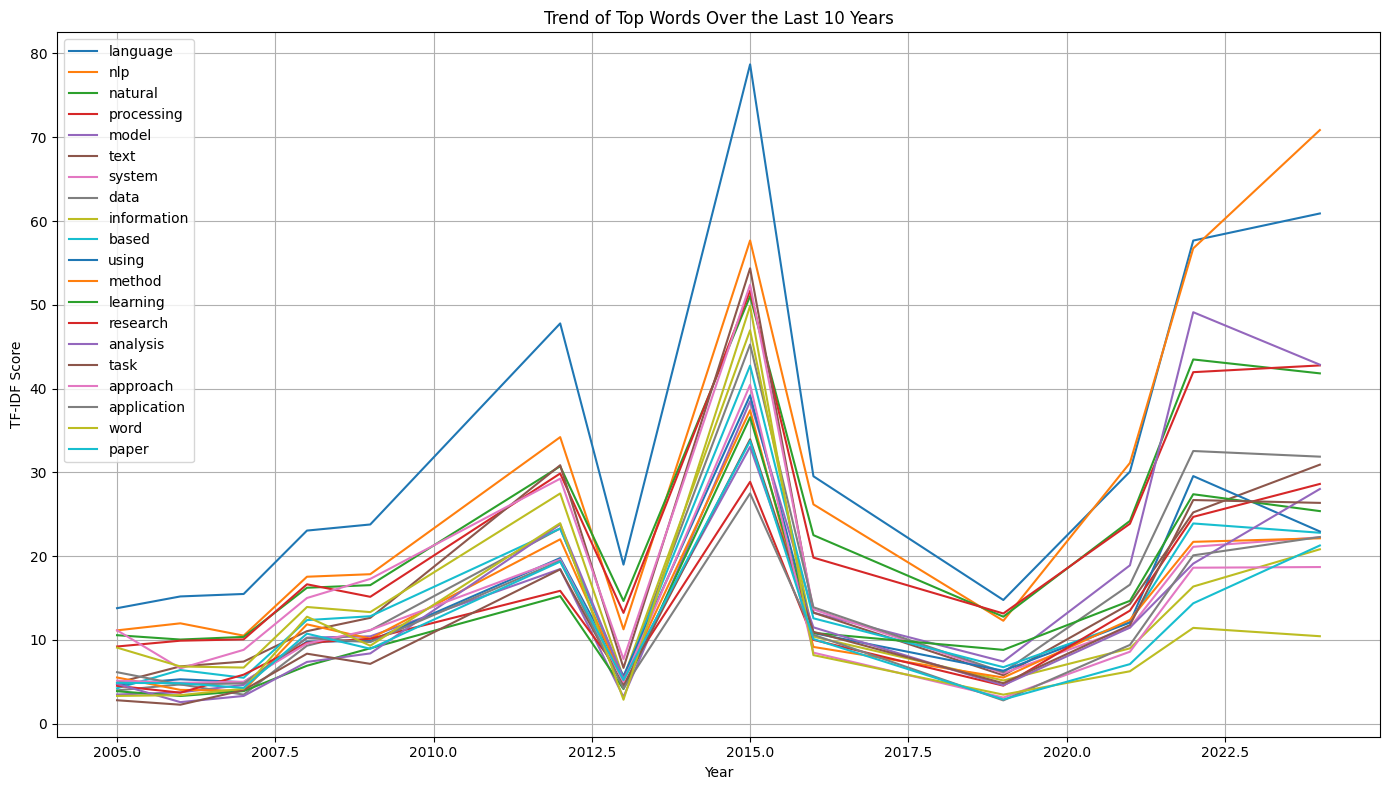

In [29]:
import matplotlib.pyplot as plt

# Plot trend for each top word
plt.figure(figsize=(14, 8))

for word in top_words.index:
    word_trend = [tfidf_per_year[year].get(word, 0) for year in years]
    plt.plot(years, word_trend, label=word)

plt.title('Trend of Top Words Over the Last 10 Years')
plt.xlabel('Year')
plt.ylabel('TF-IDF Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('word_trends.png')
plt.show()


In [30]:
from scipy.stats import pearsonr
import numpy as np

# Create a DataFrame to store TF-IDF scores for each year and word
tfidf_df = pd.DataFrame({year: tfidf_per_year[year] for year in years}).fillna(0)

# Calculate the correlation matrix
correlation_matrix = tfidf_df.corr(method='pearson')

# Find pairs of words with high correlation
correlated_words = []
threshold = 0.8  # Set a correlation threshold
for word1 in correlation_matrix.columns:
    for word2 in correlation_matrix.columns:
        if word1 != word2:
            correlation = correlation_matrix.at[word1, word2]
            if correlation > threshold:
                correlated_words.append((word1, word2, correlation))

# Display highly correlated word pairs
correlated_words = sorted(correlated_words, key=lambda x: x[2], reverse=True)
for word1, word2, correlation in correlated_words:
    print(f"Word Pair: {word1} - {word2}, Correlation: {correlation:.2f}")


Word Pair: 2021 - 2022, Correlation: 0.90
Word Pair: 2022 - 2021, Correlation: 0.90
Word Pair: 2012 - 2015, Correlation: 0.89
Word Pair: 2015 - 2012, Correlation: 0.89
Word Pair: 2009 - 2012, Correlation: 0.87
Word Pair: 2012 - 2009, Correlation: 0.87
Word Pair: 2008 - 2009, Correlation: 0.87
Word Pair: 2009 - 2008, Correlation: 0.87
Word Pair: 2013 - 2016, Correlation: 0.87
Word Pair: 2016 - 2013, Correlation: 0.87
Word Pair: 2015 - 2016, Correlation: 0.86
Word Pair: 2016 - 2015, Correlation: 0.86
Word Pair: 2009 - 2015, Correlation: 0.86
Word Pair: 2015 - 2009, Correlation: 0.86
Word Pair: 2021 - 2024, Correlation: 0.86
Word Pair: 2024 - 2021, Correlation: 0.86
Word Pair: 2008 - 2015, Correlation: 0.86
Word Pair: 2015 - 2008, Correlation: 0.86
Word Pair: 2007 - 2009, Correlation: 0.85
Word Pair: 2009 - 2007, Correlation: 0.85
Word Pair: 2016 - 2021, Correlation: 0.85
Word Pair: 2021 - 2016, Correlation: 0.85
Word Pair: 2008 - 2012, Correlation: 0.85
Word Pair: 2012 - 2008, Correlatio

# **Section 10 - Summarization**

In [31]:
!pip install transformers
!pip install torch


In [32]:
from transformers import pipeline

# Load the summarization pipeline using a pre-trained model
summarizer = pipeline("summarization", model="t5-small")


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [33]:


import json

# Load the processed articles
with open('processed_nlp_articles.json', 'r', encoding='utf-8') as f:
    articles = json.load(f)

# Add a summarized abstract to each article
for i, article in enumerate(articles):
    print(f"Summarizing abstract for article {i+1}/{len(articles)}")
    abstract = article.get('abstract', '')

    # Check if abstract is a valid string
    if isinstance(abstract, str) and abstract.strip():
        summary = summarizer(abstract, max_length=100, min_length=30, do_sample=False)
        article['summary'] = summary[0]['summary_text']
    else:
        article['summary'] = 'N/A'

# Save the articles with summaries
with open('nlp_articles_with_summaries.json', 'w', encoding='utf-8') as f:
    json.dump(articles, f, ensure_ascii=False, indent=2)

print("Summarization completed and results saved to 'nlp_articles_with_summaries.json'")



Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


Summarizing abstract for article 1/3114
Summarizing abstract for article 2/3114
Summarizing abstract for article 3/3114
Summarizing abstract for article 4/3114
Summarizing abstract for article 5/3114
Summarizing abstract for article 6/3114
Summarizing abstract for article 7/3114
Summarizing abstract for article 8/3114
Summarizing abstract for article 9/3114
Summarizing abstract for article 10/3114
Summarizing abstract for article 11/3114
Summarizing abstract for article 12/3114


Your max_length is set to 100, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Summarizing abstract for article 13/3114
Summarizing abstract for article 14/3114
Summarizing abstract for article 15/3114
Summarizing abstract for article 16/3114
Summarizing abstract for article 17/3114
Summarizing abstract for article 18/3114
Summarizing abstract for article 19/3114
Summarizing abstract for article 20/3114
Summarizing abstract for article 21/3114
Summarizing abstract for article 22/3114
Summarizing abstract for article 23/3114
Summarizing abstract for article 24/3114
Summarizing abstract for article 25/3114
Summarizing abstract for article 26/3114
Summarizing abstract for article 27/3114
Summarizing abstract for article 28/3114
Summarizing abstract for article 29/3114
Summarizing abstract for article 30/3114
Summarizing abstract for article 31/3114
Summarizing abstract for article 32/3114
Summarizing abstract for article 33/3114
Summarizing abstract for article 34/3114
Summarizing abstract for article 35/3114
Summarizing abstract for article 36/3114
Summarizing abst

Your max_length is set to 100, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Summarizing abstract for article 92/3114
Summarizing abstract for article 93/3114
Summarizing abstract for article 94/3114
Summarizing abstract for article 95/3114
Summarizing abstract for article 96/3114
Summarizing abstract for article 97/3114
Summarizing abstract for article 98/3114
Summarizing abstract for article 99/3114
Summarizing abstract for article 100/3114
Summarizing abstract for article 101/3114
Summarizing abstract for article 102/3114
Summarizing abstract for article 103/3114
Summarizing abstract for article 104/3114
Summarizing abstract for article 105/3114
Summarizing abstract for article 106/3114
Summarizing abstract for article 107/3114
Summarizing abstract for article 108/3114
Summarizing abstract for article 109/3114
Summarizing abstract for article 110/3114
Summarizing abstract for article 111/3114
Summarizing abstract for article 112/3114
Summarizing abstract for article 113/3114
Summarizing abstract for article 114/3114
Summarizing abstract for article 115/3114


Your max_length is set to 100, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Summarizing abstract for article 170/3114
Summarizing abstract for article 171/3114
Summarizing abstract for article 172/3114
Summarizing abstract for article 173/3114
Summarizing abstract for article 174/3114
Summarizing abstract for article 175/3114
Summarizing abstract for article 176/3114
Summarizing abstract for article 177/3114
Summarizing abstract for article 178/3114
Summarizing abstract for article 179/3114
Summarizing abstract for article 180/3114
Summarizing abstract for article 181/3114


Your max_length is set to 100, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Summarizing abstract for article 182/3114
Summarizing abstract for article 183/3114
Summarizing abstract for article 184/3114
Summarizing abstract for article 185/3114
Summarizing abstract for article 186/3114
Summarizing abstract for article 187/3114
Summarizing abstract for article 188/3114
Summarizing abstract for article 189/3114
Summarizing abstract for article 190/3114
Summarizing abstract for article 191/3114
Summarizing abstract for article 192/3114
Summarizing abstract for article 193/3114
Summarizing abstract for article 194/3114
Summarizing abstract for article 195/3114
Summarizing abstract for article 196/3114
Summarizing abstract for article 197/3114
Summarizing abstract for article 198/3114
Summarizing abstract for article 199/3114
Summarizing abstract for article 200/3114
Summarizing abstract for article 201/3114
Summarizing abstract for article 202/3114
Summarizing abstract for article 203/3114
Summarizing abstract for article 204/3114
Summarizing abstract for article 2

Your max_length is set to 100, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 244/3114
Summarizing abstract for article 245/3114
Summarizing abstract for article 246/3114
Summarizing abstract for article 247/3114
Summarizing abstract for article 248/3114
Summarizing abstract for article 249/3114
Summarizing abstract for article 250/3114
Summarizing abstract for article 251/3114
Summarizing abstract for article 252/3114
Summarizing abstract for article 253/3114
Summarizing abstract for article 254/3114
Summarizing abstract for article 255/3114
Summarizing abstract for article 256/3114
Summarizing abstract for article 257/3114
Summarizing abstract for article 258/3114
Summarizing abstract for article 259/3114
Summarizing abstract for article 260/3114
Summarizing abstract for article 261/3114
Summarizing abstract for article 262/3114
Summarizing abstract for article 263/3114
Summarizing abstract for article 264/3114
Summarizing abstract for article 265/3114
Summarizing abstract for article 266/3114
Summarizing abstract for article 2

Your max_length is set to 100, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarizing abstract for article 356/3114
Summarizing abstract for article 357/3114
Summarizing abstract for article 358/3114
Summarizing abstract for article 359/3114
Summarizing abstract for article 360/3114
Summarizing abstract for article 361/3114
Summarizing abstract for article 362/3114
Summarizing abstract for article 363/3114
Summarizing abstract for article 364/3114
Summarizing abstract for article 365/3114
Summarizing abstract for article 366/3114
Summarizing abstract for article 367/3114
Summarizing abstract for article 368/3114
Summarizing abstract for article 369/3114
Summarizing abstract for article 370/3114
Summarizing abstract for article 371/3114
Summarizing abstract for article 372/3114
Summarizing abstract for article 373/3114
Summarizing abstract for article 374/3114
Summarizing abstract for article 375/3114
Summarizing abstract for article 376/3114
Summarizing abstract for article 377/3114
Summarizing abstract for article 378/3114
Summarizing abstract for article 3

Your max_length is set to 100, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Summarizing abstract for article 489/3114
Summarizing abstract for article 490/3114
Summarizing abstract for article 491/3114
Summarizing abstract for article 492/3114
Summarizing abstract for article 493/3114
Summarizing abstract for article 494/3114
Summarizing abstract for article 495/3114
Summarizing abstract for article 496/3114
Summarizing abstract for article 497/3114
Summarizing abstract for article 498/3114
Summarizing abstract for article 499/3114
Summarizing abstract for article 500/3114
Summarizing abstract for article 501/3114
Summarizing abstract for article 502/3114
Summarizing abstract for article 503/3114
Summarizing abstract for article 504/3114
Summarizing abstract for article 505/3114
Summarizing abstract for article 506/3114
Summarizing abstract for article 507/3114
Summarizing abstract for article 508/3114
Summarizing abstract for article 509/3114
Summarizing abstract for article 510/3114
Summarizing abstract for article 511/3114
Summarizing abstract for article 5

Your max_length is set to 100, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summarizing abstract for article 579/3114
Summarizing abstract for article 580/3114
Summarizing abstract for article 581/3114
Summarizing abstract for article 582/3114
Summarizing abstract for article 583/3114
Summarizing abstract for article 584/3114
Summarizing abstract for article 585/3114
Summarizing abstract for article 586/3114
Summarizing abstract for article 587/3114
Summarizing abstract for article 588/3114
Summarizing abstract for article 589/3114
Summarizing abstract for article 590/3114
Summarizing abstract for article 591/3114
Summarizing abstract for article 592/3114
Summarizing abstract for article 593/3114
Summarizing abstract for article 594/3114
Summarizing abstract for article 595/3114
Summarizing abstract for article 596/3114
Summarizing abstract for article 597/3114
Summarizing abstract for article 598/3114
Summarizing abstract for article 599/3114
Summarizing abstract for article 600/3114
Summarizing abstract for article 601/3114
Summarizing abstract for article 6

Your max_length is set to 100, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarizing abstract for article 769/3114
Summarizing abstract for article 770/3114
Summarizing abstract for article 771/3114
Summarizing abstract for article 772/3114
Summarizing abstract for article 773/3114
Summarizing abstract for article 774/3114
Summarizing abstract for article 775/3114
Summarizing abstract for article 776/3114
Summarizing abstract for article 777/3114
Summarizing abstract for article 778/3114
Summarizing abstract for article 779/3114
Summarizing abstract for article 780/3114
Summarizing abstract for article 781/3114
Summarizing abstract for article 782/3114
Summarizing abstract for article 783/3114
Summarizing abstract for article 784/3114
Summarizing abstract for article 785/3114
Summarizing abstract for article 786/3114
Summarizing abstract for article 787/3114
Summarizing abstract for article 788/3114
Summarizing abstract for article 789/3114
Summarizing abstract for article 790/3114
Summarizing abstract for article 791/3114
Summarizing abstract for article 7

Your max_length is set to 100, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summarizing abstract for article 925/3114
Summarizing abstract for article 926/3114
Summarizing abstract for article 927/3114
Summarizing abstract for article 928/3114
Summarizing abstract for article 929/3114
Summarizing abstract for article 930/3114
Summarizing abstract for article 931/3114
Summarizing abstract for article 932/3114
Summarizing abstract for article 933/3114
Summarizing abstract for article 934/3114
Summarizing abstract for article 935/3114
Summarizing abstract for article 936/3114
Summarizing abstract for article 937/3114
Summarizing abstract for article 938/3114
Summarizing abstract for article 939/3114
Summarizing abstract for article 940/3114
Summarizing abstract for article 941/3114
Summarizing abstract for article 942/3114
Summarizing abstract for article 943/3114
Summarizing abstract for article 944/3114
Summarizing abstract for article 945/3114
Summarizing abstract for article 946/3114
Summarizing abstract for article 947/3114
Summarizing abstract for article 9

Your max_length is set to 100, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Summarizing abstract for article 1002/3114
Summarizing abstract for article 1003/3114
Summarizing abstract for article 1004/3114
Summarizing abstract for article 1005/3114
Summarizing abstract for article 1006/3114
Summarizing abstract for article 1007/3114
Summarizing abstract for article 1008/3114
Summarizing abstract for article 1009/3114
Summarizing abstract for article 1010/3114
Summarizing abstract for article 1011/3114
Summarizing abstract for article 1012/3114
Summarizing abstract for article 1013/3114
Summarizing abstract for article 1014/3114
Summarizing abstract for article 1015/3114
Summarizing abstract for article 1016/3114
Summarizing abstract for article 1017/3114
Summarizing abstract for article 1018/3114
Summarizing abstract for article 1019/3114
Summarizing abstract for article 1020/3114
Summarizing abstract for article 1021/3114
Summarizing abstract for article 1022/3114
Summarizing abstract for article 1023/3114
Summarizing abstract for article 1024/3114
Summarizing

Your max_length is set to 100, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Summarizing abstract for article 1058/3114
Summarizing abstract for article 1059/3114
Summarizing abstract for article 1060/3114
Summarizing abstract for article 1061/3114
Summarizing abstract for article 1062/3114
Summarizing abstract for article 1063/3114
Summarizing abstract for article 1064/3114
Summarizing abstract for article 1065/3114
Summarizing abstract for article 1066/3114
Summarizing abstract for article 1067/3114
Summarizing abstract for article 1068/3114
Summarizing abstract for article 1069/3114
Summarizing abstract for article 1070/3114
Summarizing abstract for article 1071/3114
Summarizing abstract for article 1072/3114
Summarizing abstract for article 1073/3114
Summarizing abstract for article 1074/3114
Summarizing abstract for article 1075/3114


Your max_length is set to 100, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Summarizing abstract for article 1076/3114
Summarizing abstract for article 1077/3114
Summarizing abstract for article 1078/3114
Summarizing abstract for article 1079/3114


Your max_length is set to 100, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Summarizing abstract for article 1080/3114
Summarizing abstract for article 1081/3114
Summarizing abstract for article 1082/3114
Summarizing abstract for article 1083/3114
Summarizing abstract for article 1084/3114
Summarizing abstract for article 1085/3114
Summarizing abstract for article 1086/3114
Summarizing abstract for article 1087/3114
Summarizing abstract for article 1088/3114
Summarizing abstract for article 1089/3114
Summarizing abstract for article 1090/3114
Summarizing abstract for article 1091/3114
Summarizing abstract for article 1092/3114
Summarizing abstract for article 1093/3114
Summarizing abstract for article 1094/3114
Summarizing abstract for article 1095/3114
Summarizing abstract for article 1096/3114
Summarizing abstract for article 1097/3114
Summarizing abstract for article 1098/3114
Summarizing abstract for article 1099/3114
Summarizing abstract for article 1100/3114
Summarizing abstract for article 1101/3114
Summarizing abstract for article 1102/3114
Summarizing

Your max_length is set to 100, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 1138/3114
Summarizing abstract for article 1139/3114
Summarizing abstract for article 1140/3114
Summarizing abstract for article 1141/3114
Summarizing abstract for article 1142/3114
Summarizing abstract for article 1143/3114
Summarizing abstract for article 1144/3114
Summarizing abstract for article 1145/3114
Summarizing abstract for article 1146/3114
Summarizing abstract for article 1147/3114
Summarizing abstract for article 1148/3114
Summarizing abstract for article 1149/3114
Summarizing abstract for article 1150/3114
Summarizing abstract for article 1151/3114
Summarizing abstract for article 1152/3114
Summarizing abstract for article 1153/3114
Summarizing abstract for article 1154/3114
Summarizing abstract for article 1155/3114


Your max_length is set to 100, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Summarizing abstract for article 1156/3114
Summarizing abstract for article 1157/3114
Summarizing abstract for article 1158/3114
Summarizing abstract for article 1159/3114
Summarizing abstract for article 1160/3114
Summarizing abstract for article 1161/3114
Summarizing abstract for article 1162/3114
Summarizing abstract for article 1163/3114
Summarizing abstract for article 1164/3114
Summarizing abstract for article 1165/3114
Summarizing abstract for article 1166/3114
Summarizing abstract for article 1167/3114
Summarizing abstract for article 1168/3114
Summarizing abstract for article 1169/3114
Summarizing abstract for article 1170/3114
Summarizing abstract for article 1171/3114


Your max_length is set to 100, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Summarizing abstract for article 1172/3114


Your max_length is set to 100, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 1173/3114
Summarizing abstract for article 1174/3114
Summarizing abstract for article 1175/3114
Summarizing abstract for article 1176/3114
Summarizing abstract for article 1177/3114
Summarizing abstract for article 1178/3114


Your max_length is set to 100, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Summarizing abstract for article 1179/3114
Summarizing abstract for article 1180/3114


Your max_length is set to 100, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarizing abstract for article 1181/3114
Summarizing abstract for article 1182/3114
Summarizing abstract for article 1183/3114
Summarizing abstract for article 1184/3114
Summarizing abstract for article 1185/3114
Summarizing abstract for article 1186/3114


Your max_length is set to 100, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summarizing abstract for article 1187/3114
Summarizing abstract for article 1188/3114
Summarizing abstract for article 1189/3114
Summarizing abstract for article 1190/3114
Summarizing abstract for article 1191/3114
Summarizing abstract for article 1192/3114
Summarizing abstract for article 1193/3114
Summarizing abstract for article 1194/3114
Summarizing abstract for article 1195/3114


Your max_length is set to 100, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Summarizing abstract for article 1196/3114
Summarizing abstract for article 1197/3114


Your max_length is set to 100, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Summarizing abstract for article 1198/3114
Summarizing abstract for article 1199/3114
Summarizing abstract for article 1200/3114
Summarizing abstract for article 1201/3114
Summarizing abstract for article 1202/3114
Summarizing abstract for article 1203/3114
Summarizing abstract for article 1204/3114
Summarizing abstract for article 1205/3114
Summarizing abstract for article 1206/3114
Summarizing abstract for article 1207/3114


Your max_length is set to 100, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Summarizing abstract for article 1208/3114
Summarizing abstract for article 1209/3114
Summarizing abstract for article 1210/3114
Summarizing abstract for article 1211/3114
Summarizing abstract for article 1212/3114
Summarizing abstract for article 1213/3114
Summarizing abstract for article 1214/3114
Summarizing abstract for article 1215/3114
Summarizing abstract for article 1216/3114
Summarizing abstract for article 1217/3114
Summarizing abstract for article 1218/3114
Summarizing abstract for article 1219/3114
Summarizing abstract for article 1220/3114
Summarizing abstract for article 1221/3114
Summarizing abstract for article 1222/3114
Summarizing abstract for article 1223/3114
Summarizing abstract for article 1224/3114
Summarizing abstract for article 1225/3114
Summarizing abstract for article 1226/3114
Summarizing abstract for article 1227/3114
Summarizing abstract for article 1228/3114
Summarizing abstract for article 1229/3114
Summarizing abstract for article 1230/3114
Summarizing

Your max_length is set to 100, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarizing abstract for article 1240/3114
Summarizing abstract for article 1241/3114
Summarizing abstract for article 1242/3114
Summarizing abstract for article 1243/3114
Summarizing abstract for article 1244/3114
Summarizing abstract for article 1245/3114
Summarizing abstract for article 1246/3114
Summarizing abstract for article 1247/3114
Summarizing abstract for article 1248/3114
Summarizing abstract for article 1249/3114
Summarizing abstract for article 1250/3114
Summarizing abstract for article 1251/3114
Summarizing abstract for article 1252/3114
Summarizing abstract for article 1253/3114
Summarizing abstract for article 1254/3114
Summarizing abstract for article 1255/3114
Summarizing abstract for article 1256/3114
Summarizing abstract for article 1257/3114
Summarizing abstract for article 1258/3114
Summarizing abstract for article 1259/3114
Summarizing abstract for article 1260/3114
Summarizing abstract for article 1261/3114
Summarizing abstract for article 1262/3114
Summarizing

Your max_length is set to 100, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summarizing abstract for article 1272/3114
Summarizing abstract for article 1273/3114
Summarizing abstract for article 1274/3114
Summarizing abstract for article 1275/3114
Summarizing abstract for article 1276/3114
Summarizing abstract for article 1277/3114
Summarizing abstract for article 1278/3114
Summarizing abstract for article 1279/3114
Summarizing abstract for article 1280/3114
Summarizing abstract for article 1281/3114
Summarizing abstract for article 1282/3114
Summarizing abstract for article 1283/3114


Your max_length is set to 100, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Summarizing abstract for article 1284/3114
Summarizing abstract for article 1285/3114
Summarizing abstract for article 1286/3114
Summarizing abstract for article 1287/3114
Summarizing abstract for article 1288/3114
Summarizing abstract for article 1289/3114


Your max_length is set to 100, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Summarizing abstract for article 1290/3114
Summarizing abstract for article 1291/3114


Your max_length is set to 100, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarizing abstract for article 1292/3114
Summarizing abstract for article 1293/3114
Summarizing abstract for article 1294/3114
Summarizing abstract for article 1295/3114
Summarizing abstract for article 1296/3114
Summarizing abstract for article 1297/3114
Summarizing abstract for article 1298/3114
Summarizing abstract for article 1299/3114
Summarizing abstract for article 1300/3114
Summarizing abstract for article 1301/3114
Summarizing abstract for article 1302/3114
Summarizing abstract for article 1303/3114
Summarizing abstract for article 1304/3114
Summarizing abstract for article 1305/3114
Summarizing abstract for article 1306/3114
Summarizing abstract for article 1307/3114
Summarizing abstract for article 1308/3114


Your max_length is set to 100, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summarizing abstract for article 1309/3114
Summarizing abstract for article 1310/3114
Summarizing abstract for article 1311/3114
Summarizing abstract for article 1312/3114
Summarizing abstract for article 1313/3114
Summarizing abstract for article 1314/3114
Summarizing abstract for article 1315/3114
Summarizing abstract for article 1316/3114
Summarizing abstract for article 1317/3114
Summarizing abstract for article 1318/3114
Summarizing abstract for article 1319/3114
Summarizing abstract for article 1320/3114
Summarizing abstract for article 1321/3114
Summarizing abstract for article 1322/3114
Summarizing abstract for article 1323/3114
Summarizing abstract for article 1324/3114
Summarizing abstract for article 1325/3114
Summarizing abstract for article 1326/3114
Summarizing abstract for article 1327/3114
Summarizing abstract for article 1328/3114


Your max_length is set to 100, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarizing abstract for article 1329/3114
Summarizing abstract for article 1330/3114
Summarizing abstract for article 1331/3114
Summarizing abstract for article 1332/3114
Summarizing abstract for article 1333/3114
Summarizing abstract for article 1334/3114
Summarizing abstract for article 1335/3114
Summarizing abstract for article 1336/3114
Summarizing abstract for article 1337/3114
Summarizing abstract for article 1338/3114
Summarizing abstract for article 1339/3114
Summarizing abstract for article 1340/3114
Summarizing abstract for article 1341/3114
Summarizing abstract for article 1342/3114
Summarizing abstract for article 1343/3114
Summarizing abstract for article 1344/3114
Summarizing abstract for article 1345/3114
Summarizing abstract for article 1346/3114
Summarizing abstract for article 1347/3114
Summarizing abstract for article 1348/3114
Summarizing abstract for article 1349/3114
Summarizing abstract for article 1350/3114
Summarizing abstract for article 1351/3114
Summarizing

Your max_length is set to 100, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Summarizing abstract for article 1357/3114
Summarizing abstract for article 1358/3114


Your max_length is set to 100, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Summarizing abstract for article 1359/3114
Summarizing abstract for article 1360/3114


Your max_length is set to 100, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Summarizing abstract for article 1361/3114
Summarizing abstract for article 1362/3114
Summarizing abstract for article 1363/3114
Summarizing abstract for article 1364/3114
Summarizing abstract for article 1365/3114


Your max_length is set to 100, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 1366/3114
Summarizing abstract for article 1367/3114
Summarizing abstract for article 1368/3114
Summarizing abstract for article 1369/3114
Summarizing abstract for article 1370/3114
Summarizing abstract for article 1371/3114
Summarizing abstract for article 1372/3114
Summarizing abstract for article 1373/3114
Summarizing abstract for article 1374/3114
Summarizing abstract for article 1375/3114
Summarizing abstract for article 1376/3114
Summarizing abstract for article 1377/3114
Summarizing abstract for article 1378/3114
Summarizing abstract for article 1379/3114
Summarizing abstract for article 1380/3114
Summarizing abstract for article 1381/3114
Summarizing abstract for article 1382/3114
Summarizing abstract for article 1383/3114
Summarizing abstract for article 1384/3114
Summarizing abstract for article 1385/3114
Summarizing abstract for article 1386/3114
Summarizing abstract for article 1387/3114
Summarizing abstract for article 1388/3114
Summarizing

Your max_length is set to 100, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Summarizing abstract for article 1403/3114
Summarizing abstract for article 1404/3114


Your max_length is set to 100, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summarizing abstract for article 1405/3114
Summarizing abstract for article 1406/3114
Summarizing abstract for article 1407/3114
Summarizing abstract for article 1408/3114
Summarizing abstract for article 1409/3114
Summarizing abstract for article 1410/3114
Summarizing abstract for article 1411/3114
Summarizing abstract for article 1412/3114
Summarizing abstract for article 1413/3114
Summarizing abstract for article 1414/3114
Summarizing abstract for article 1415/3114
Summarizing abstract for article 1416/3114
Summarizing abstract for article 1417/3114
Summarizing abstract for article 1418/3114
Summarizing abstract for article 1419/3114
Summarizing abstract for article 1420/3114
Summarizing abstract for article 1421/3114
Summarizing abstract for article 1422/3114
Summarizing abstract for article 1423/3114
Summarizing abstract for article 1424/3114
Summarizing abstract for article 1425/3114
Summarizing abstract for article 1426/3114
Summarizing abstract for article 1427/3114
Summarizing

Your max_length is set to 100, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 1438/3114
Summarizing abstract for article 1439/3114
Summarizing abstract for article 1440/3114
Summarizing abstract for article 1441/3114
Summarizing abstract for article 1442/3114
Summarizing abstract for article 1443/3114
Summarizing abstract for article 1444/3114
Summarizing abstract for article 1445/3114
Summarizing abstract for article 1446/3114
Summarizing abstract for article 1447/3114
Summarizing abstract for article 1448/3114
Summarizing abstract for article 1449/3114
Summarizing abstract for article 1450/3114
Summarizing abstract for article 1451/3114
Summarizing abstract for article 1452/3114


Your max_length is set to 100, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summarizing abstract for article 1453/3114
Summarizing abstract for article 1454/3114
Summarizing abstract for article 1455/3114
Summarizing abstract for article 1456/3114
Summarizing abstract for article 1457/3114
Summarizing abstract for article 1458/3114


Your max_length is set to 100, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summarizing abstract for article 1459/3114
Summarizing abstract for article 1460/3114
Summarizing abstract for article 1461/3114
Summarizing abstract for article 1462/3114
Summarizing abstract for article 1463/3114
Summarizing abstract for article 1464/3114
Summarizing abstract for article 1465/3114
Summarizing abstract for article 1466/3114
Summarizing abstract for article 1467/3114
Summarizing abstract for article 1468/3114
Summarizing abstract for article 1469/3114
Summarizing abstract for article 1470/3114
Summarizing abstract for article 1471/3114
Summarizing abstract for article 1472/3114
Summarizing abstract for article 1473/3114
Summarizing abstract for article 1474/3114
Summarizing abstract for article 1475/3114
Summarizing abstract for article 1476/3114
Summarizing abstract for article 1477/3114
Summarizing abstract for article 1478/3114
Summarizing abstract for article 1479/3114
Summarizing abstract for article 1480/3114
Summarizing abstract for article 1481/3114
Summarizing

Your max_length is set to 100, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summarizing abstract for article 1490/3114
Summarizing abstract for article 1491/3114
Summarizing abstract for article 1492/3114
Summarizing abstract for article 1493/3114
Summarizing abstract for article 1494/3114
Summarizing abstract for article 1495/3114
Summarizing abstract for article 1496/3114
Summarizing abstract for article 1497/3114
Summarizing abstract for article 1498/3114
Summarizing abstract for article 1499/3114
Summarizing abstract for article 1500/3114
Summarizing abstract for article 1501/3114
Summarizing abstract for article 1502/3114
Summarizing abstract for article 1503/3114
Summarizing abstract for article 1504/3114
Summarizing abstract for article 1505/3114
Summarizing abstract for article 1506/3114
Summarizing abstract for article 1507/3114
Summarizing abstract for article 1508/3114
Summarizing abstract for article 1509/3114
Summarizing abstract for article 1510/3114
Summarizing abstract for article 1511/3114
Summarizing abstract for article 1512/3114
Summarizing

Your max_length is set to 100, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Summarizing abstract for article 1526/3114
Summarizing abstract for article 1527/3114
Summarizing abstract for article 1528/3114
Summarizing abstract for article 1529/3114


Your max_length is set to 100, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summarizing abstract for article 1530/3114
Summarizing abstract for article 1531/3114
Summarizing abstract for article 1532/3114
Summarizing abstract for article 1533/3114
Summarizing abstract for article 1534/3114
Summarizing abstract for article 1535/3114
Summarizing abstract for article 1536/3114
Summarizing abstract for article 1537/3114
Summarizing abstract for article 1538/3114
Summarizing abstract for article 1539/3114
Summarizing abstract for article 1540/3114
Summarizing abstract for article 1541/3114
Summarizing abstract for article 1542/3114


Your max_length is set to 100, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summarizing abstract for article 1543/3114
Summarizing abstract for article 1544/3114
Summarizing abstract for article 1545/3114
Summarizing abstract for article 1546/3114
Summarizing abstract for article 1547/3114
Summarizing abstract for article 1548/3114
Summarizing abstract for article 1549/3114
Summarizing abstract for article 1550/3114
Summarizing abstract for article 1551/3114
Summarizing abstract for article 1552/3114
Summarizing abstract for article 1553/3114
Summarizing abstract for article 1554/3114
Summarizing abstract for article 1555/3114
Summarizing abstract for article 1556/3114
Summarizing abstract for article 1557/3114
Summarizing abstract for article 1558/3114
Summarizing abstract for article 1559/3114
Summarizing abstract for article 1560/3114
Summarizing abstract for article 1561/3114
Summarizing abstract for article 1562/3114
Summarizing abstract for article 1563/3114
Summarizing abstract for article 1564/3114
Summarizing abstract for article 1565/3114
Summarizing

Your max_length is set to 100, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summarizing abstract for article 1569/3114
Summarizing abstract for article 1570/3114
Summarizing abstract for article 1571/3114
Summarizing abstract for article 1572/3114
Summarizing abstract for article 1573/3114
Summarizing abstract for article 1574/3114
Summarizing abstract for article 1575/3114
Summarizing abstract for article 1576/3114
Summarizing abstract for article 1577/3114
Summarizing abstract for article 1578/3114
Summarizing abstract for article 1579/3114
Summarizing abstract for article 1580/3114
Summarizing abstract for article 1581/3114
Summarizing abstract for article 1582/3114
Summarizing abstract for article 1583/3114
Summarizing abstract for article 1584/3114
Summarizing abstract for article 1585/3114
Summarizing abstract for article 1586/3114
Summarizing abstract for article 1587/3114
Summarizing abstract for article 1588/3114
Summarizing abstract for article 1589/3114
Summarizing abstract for article 1590/3114
Summarizing abstract for article 1591/3114
Summarizing

Your max_length is set to 100, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Summarizing abstract for article 1681/3114
Summarizing abstract for article 1682/3114
Summarizing abstract for article 1683/3114
Summarizing abstract for article 1684/3114
Summarizing abstract for article 1685/3114
Summarizing abstract for article 1686/3114
Summarizing abstract for article 1687/3114
Summarizing abstract for article 1688/3114
Summarizing abstract for article 1689/3114
Summarizing abstract for article 1690/3114
Summarizing abstract for article 1691/3114
Summarizing abstract for article 1692/3114
Summarizing abstract for article 1693/3114
Summarizing abstract for article 1694/3114
Summarizing abstract for article 1695/3114
Summarizing abstract for article 1696/3114
Summarizing abstract for article 1697/3114
Summarizing abstract for article 1698/3114
Summarizing abstract for article 1699/3114
Summarizing abstract for article 1700/3114
Summarizing abstract for article 1701/3114
Summarizing abstract for article 1702/3114
Summarizing abstract for article 1703/3114
Summarizing

Your max_length is set to 100, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Summarizing abstract for article 1755/3114
Summarizing abstract for article 1756/3114
Summarizing abstract for article 1757/3114
Summarizing abstract for article 1758/3114
Summarizing abstract for article 1759/3114
Summarizing abstract for article 1760/3114
Summarizing abstract for article 1761/3114
Summarizing abstract for article 1762/3114
Summarizing abstract for article 1763/3114
Summarizing abstract for article 1764/3114
Summarizing abstract for article 1765/3114
Summarizing abstract for article 1766/3114
Summarizing abstract for article 1767/3114
Summarizing abstract for article 1768/3114
Summarizing abstract for article 1769/3114
Summarizing abstract for article 1770/3114
Summarizing abstract for article 1771/3114
Summarizing abstract for article 1772/3114
Summarizing abstract for article 1773/3114
Summarizing abstract for article 1774/3114
Summarizing abstract for article 1775/3114
Summarizing abstract for article 1776/3114
Summarizing abstract for article 1777/3114
Summarizing

Your max_length is set to 100, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summarizing abstract for article 1815/3114
Summarizing abstract for article 1816/3114
Summarizing abstract for article 1817/3114
Summarizing abstract for article 1818/3114
Summarizing abstract for article 1819/3114
Summarizing abstract for article 1820/3114
Summarizing abstract for article 1821/3114
Summarizing abstract for article 1822/3114
Summarizing abstract for article 1823/3114
Summarizing abstract for article 1824/3114
Summarizing abstract for article 1825/3114
Summarizing abstract for article 1826/3114
Summarizing abstract for article 1827/3114


Your max_length is set to 100, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Summarizing abstract for article 1828/3114
Summarizing abstract for article 1829/3114


Your max_length is set to 100, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Summarizing abstract for article 1830/3114
Summarizing abstract for article 1831/3114
Summarizing abstract for article 1832/3114


Your max_length is set to 100, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Summarizing abstract for article 1833/3114
Summarizing abstract for article 1834/3114
Summarizing abstract for article 1835/3114
Summarizing abstract for article 1836/3114
Summarizing abstract for article 1837/3114
Summarizing abstract for article 1838/3114
Summarizing abstract for article 1839/3114
Summarizing abstract for article 1840/3114
Summarizing abstract for article 1841/3114
Summarizing abstract for article 1842/3114
Summarizing abstract for article 1843/3114
Summarizing abstract for article 1844/3114
Summarizing abstract for article 1845/3114
Summarizing abstract for article 1846/3114
Summarizing abstract for article 1847/3114


Your max_length is set to 100, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarizing abstract for article 1848/3114
Summarizing abstract for article 1849/3114
Summarizing abstract for article 1850/3114
Summarizing abstract for article 1851/3114
Summarizing abstract for article 1852/3114
Summarizing abstract for article 1853/3114
Summarizing abstract for article 1854/3114
Summarizing abstract for article 1855/3114
Summarizing abstract for article 1856/3114
Summarizing abstract for article 1857/3114
Summarizing abstract for article 1858/3114
Summarizing abstract for article 1859/3114
Summarizing abstract for article 1860/3114
Summarizing abstract for article 1861/3114


Your max_length is set to 100, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Summarizing abstract for article 1862/3114
Summarizing abstract for article 1863/3114
Summarizing abstract for article 1864/3114
Summarizing abstract for article 1865/3114
Summarizing abstract for article 1866/3114
Summarizing abstract for article 1867/3114
Summarizing abstract for article 1868/3114
Summarizing abstract for article 1869/3114
Summarizing abstract for article 1870/3114
Summarizing abstract for article 1871/3114
Summarizing abstract for article 1872/3114
Summarizing abstract for article 1873/3114
Summarizing abstract for article 1874/3114
Summarizing abstract for article 1875/3114
Summarizing abstract for article 1876/3114
Summarizing abstract for article 1877/3114


Your max_length is set to 100, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Summarizing abstract for article 1878/3114
Summarizing abstract for article 1879/3114
Summarizing abstract for article 1880/3114
Summarizing abstract for article 1881/3114
Summarizing abstract for article 1882/3114
Summarizing abstract for article 1883/3114
Summarizing abstract for article 1884/3114
Summarizing abstract for article 1885/3114
Summarizing abstract for article 1886/3114
Summarizing abstract for article 1887/3114


Your max_length is set to 100, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Summarizing abstract for article 1888/3114
Summarizing abstract for article 1889/3114
Summarizing abstract for article 1890/3114
Summarizing abstract for article 1891/3114
Summarizing abstract for article 1892/3114
Summarizing abstract for article 1893/3114
Summarizing abstract for article 1894/3114
Summarizing abstract for article 1895/3114
Summarizing abstract for article 1896/3114
Summarizing abstract for article 1897/3114
Summarizing abstract for article 1898/3114
Summarizing abstract for article 1899/3114
Summarizing abstract for article 1900/3114
Summarizing abstract for article 1901/3114
Summarizing abstract for article 1902/3114
Summarizing abstract for article 1903/3114
Summarizing abstract for article 1904/3114
Summarizing abstract for article 1905/3114
Summarizing abstract for article 1906/3114
Summarizing abstract for article 1907/3114
Summarizing abstract for article 1908/3114
Summarizing abstract for article 1909/3114
Summarizing abstract for article 1910/3114
Summarizing

Your max_length is set to 100, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Summarizing abstract for article 1988/3114
Summarizing abstract for article 1989/3114
Summarizing abstract for article 1990/3114
Summarizing abstract for article 1991/3114
Summarizing abstract for article 1992/3114
Summarizing abstract for article 1993/3114
Summarizing abstract for article 1994/3114
Summarizing abstract for article 1995/3114
Summarizing abstract for article 1996/3114
Summarizing abstract for article 1997/3114
Summarizing abstract for article 1998/3114
Summarizing abstract for article 1999/3114
Summarizing abstract for article 2000/3114
Summarizing abstract for article 2001/3114
Summarizing abstract for article 2002/3114
Summarizing abstract for article 2003/3114
Summarizing abstract for article 2004/3114
Summarizing abstract for article 2005/3114
Summarizing abstract for article 2006/3114
Summarizing abstract for article 2007/3114
Summarizing abstract for article 2008/3114
Summarizing abstract for article 2009/3114
Summarizing abstract for article 2010/3114
Summarizing

Your max_length is set to 100, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarizing abstract for article 2026/3114
Summarizing abstract for article 2027/3114
Summarizing abstract for article 2028/3114
Summarizing abstract for article 2029/3114
Summarizing abstract for article 2030/3114
Summarizing abstract for article 2031/3114
Summarizing abstract for article 2032/3114
Summarizing abstract for article 2033/3114
Summarizing abstract for article 2034/3114
Summarizing abstract for article 2035/3114
Summarizing abstract for article 2036/3114
Summarizing abstract for article 2037/3114
Summarizing abstract for article 2038/3114
Summarizing abstract for article 2039/3114
Summarizing abstract for article 2040/3114
Summarizing abstract for article 2041/3114
Summarizing abstract for article 2042/3114
Summarizing abstract for article 2043/3114
Summarizing abstract for article 2044/3114
Summarizing abstract for article 2045/3114
Summarizing abstract for article 2046/3114
Summarizing abstract for article 2047/3114


Your max_length is set to 100, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 2048/3114
Summarizing abstract for article 2049/3114


Your max_length is set to 100, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Summarizing abstract for article 2050/3114
Summarizing abstract for article 2051/3114
Summarizing abstract for article 2052/3114
Summarizing abstract for article 2053/3114
Summarizing abstract for article 2054/3114
Summarizing abstract for article 2055/3114
Summarizing abstract for article 2056/3114
Summarizing abstract for article 2057/3114
Summarizing abstract for article 2058/3114
Summarizing abstract for article 2059/3114
Summarizing abstract for article 2060/3114
Summarizing abstract for article 2061/3114
Summarizing abstract for article 2062/3114
Summarizing abstract for article 2063/3114
Summarizing abstract for article 2064/3114
Summarizing abstract for article 2065/3114
Summarizing abstract for article 2066/3114


Your max_length is set to 100, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 2067/3114


Your max_length is set to 100, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Summarizing abstract for article 2068/3114
Summarizing abstract for article 2069/3114
Summarizing abstract for article 2070/3114
Summarizing abstract for article 2071/3114
Summarizing abstract for article 2072/3114
Summarizing abstract for article 2073/3114
Summarizing abstract for article 2074/3114


Your max_length is set to 100, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarizing abstract for article 2075/3114
Summarizing abstract for article 2076/3114
Summarizing abstract for article 2077/3114
Summarizing abstract for article 2078/3114
Summarizing abstract for article 2079/3114
Summarizing abstract for article 2080/3114
Summarizing abstract for article 2081/3114
Summarizing abstract for article 2082/3114
Summarizing abstract for article 2083/3114
Summarizing abstract for article 2084/3114


Your max_length is set to 100, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summarizing abstract for article 2085/3114
Summarizing abstract for article 2086/3114


Your max_length is set to 100, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarizing abstract for article 2087/3114
Summarizing abstract for article 2088/3114
Summarizing abstract for article 2089/3114
Summarizing abstract for article 2090/3114
Summarizing abstract for article 2091/3114
Summarizing abstract for article 2092/3114
Summarizing abstract for article 2093/3114
Summarizing abstract for article 2094/3114
Summarizing abstract for article 2095/3114
Summarizing abstract for article 2096/3114
Summarizing abstract for article 2097/3114
Summarizing abstract for article 2098/3114
Summarizing abstract for article 2099/3114
Summarizing abstract for article 2100/3114
Summarizing abstract for article 2101/3114
Summarizing abstract for article 2102/3114
Summarizing abstract for article 2103/3114
Summarizing abstract for article 2104/3114
Summarizing abstract for article 2105/3114
Summarizing abstract for article 2106/3114
Summarizing abstract for article 2107/3114
Summarizing abstract for article 2108/3114
Summarizing abstract for article 2109/3114
Summarizing

Your max_length is set to 100, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Summarizing abstract for article 2127/3114
Summarizing abstract for article 2128/3114
Summarizing abstract for article 2129/3114
Summarizing abstract for article 2130/3114
Summarizing abstract for article 2131/3114
Summarizing abstract for article 2132/3114
Summarizing abstract for article 2133/3114
Summarizing abstract for article 2134/3114
Summarizing abstract for article 2135/3114
Summarizing abstract for article 2136/3114
Summarizing abstract for article 2137/3114
Summarizing abstract for article 2138/3114
Summarizing abstract for article 2139/3114
Summarizing abstract for article 2140/3114
Summarizing abstract for article 2141/3114


Your max_length is set to 100, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarizing abstract for article 2142/3114
Summarizing abstract for article 2143/3114
Summarizing abstract for article 2144/3114
Summarizing abstract for article 2145/3114


Your max_length is set to 100, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarizing abstract for article 2146/3114
Summarizing abstract for article 2147/3114
Summarizing abstract for article 2148/3114
Summarizing abstract for article 2149/3114
Summarizing abstract for article 2150/3114
Summarizing abstract for article 2151/3114
Summarizing abstract for article 2152/3114
Summarizing abstract for article 2153/3114
Summarizing abstract for article 2154/3114
Summarizing abstract for article 2155/3114
Summarizing abstract for article 2156/3114
Summarizing abstract for article 2157/3114
Summarizing abstract for article 2158/3114
Summarizing abstract for article 2159/3114
Summarizing abstract for article 2160/3114
Summarizing abstract for article 2161/3114
Summarizing abstract for article 2162/3114
Summarizing abstract for article 2163/3114
Summarizing abstract for article 2164/3114


Your max_length is set to 100, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Summarizing abstract for article 2165/3114
Summarizing abstract for article 2166/3114
Summarizing abstract for article 2167/3114
Summarizing abstract for article 2168/3114
Summarizing abstract for article 2169/3114
Summarizing abstract for article 2170/3114
Summarizing abstract for article 2171/3114


Your max_length is set to 100, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Summarizing abstract for article 2172/3114
Summarizing abstract for article 2173/3114
Summarizing abstract for article 2174/3114
Summarizing abstract for article 2175/3114
Summarizing abstract for article 2176/3114
Summarizing abstract for article 2177/3114
Summarizing abstract for article 2178/3114
Summarizing abstract for article 2179/3114
Summarizing abstract for article 2180/3114
Summarizing abstract for article 2181/3114
Summarizing abstract for article 2182/3114
Summarizing abstract for article 2183/3114
Summarizing abstract for article 2184/3114
Summarizing abstract for article 2185/3114
Summarizing abstract for article 2186/3114
Summarizing abstract for article 2187/3114
Summarizing abstract for article 2188/3114
Summarizing abstract for article 2189/3114
Summarizing abstract for article 2190/3114
Summarizing abstract for article 2191/3114
Summarizing abstract for article 2192/3114
Summarizing abstract for article 2193/3114
Summarizing abstract for article 2194/3114
Summarizing

Your max_length is set to 100, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Summarizing abstract for article 2208/3114
Summarizing abstract for article 2209/3114
Summarizing abstract for article 2210/3114
Summarizing abstract for article 2211/3114
Summarizing abstract for article 2212/3114
Summarizing abstract for article 2213/3114
Summarizing abstract for article 2214/3114
Summarizing abstract for article 2215/3114
Summarizing abstract for article 2216/3114
Summarizing abstract for article 2217/3114
Summarizing abstract for article 2218/3114
Summarizing abstract for article 2219/3114
Summarizing abstract for article 2220/3114
Summarizing abstract for article 2221/3114
Summarizing abstract for article 2222/3114
Summarizing abstract for article 2223/3114
Summarizing abstract for article 2224/3114
Summarizing abstract for article 2225/3114
Summarizing abstract for article 2226/3114
Summarizing abstract for article 2227/3114
Summarizing abstract for article 2228/3114
Summarizing abstract for article 2229/3114
Summarizing abstract for article 2230/3114
Summarizing

Your max_length is set to 100, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Summarizing abstract for article 2252/3114
Summarizing abstract for article 2253/3114
Summarizing abstract for article 2254/3114


Your max_length is set to 100, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summarizing abstract for article 2255/3114


Your max_length is set to 100, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Summarizing abstract for article 2256/3114
Summarizing abstract for article 2257/3114
Summarizing abstract for article 2258/3114
Summarizing abstract for article 2259/3114
Summarizing abstract for article 2260/3114
Summarizing abstract for article 2261/3114
Summarizing abstract for article 2262/3114
Summarizing abstract for article 2263/3114
Summarizing abstract for article 2264/3114
Summarizing abstract for article 2265/3114
Summarizing abstract for article 2266/3114
Summarizing abstract for article 2267/3114
Summarizing abstract for article 2268/3114
Summarizing abstract for article 2269/3114
Summarizing abstract for article 2270/3114
Summarizing abstract for article 2271/3114


Your max_length is set to 100, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 2272/3114
Summarizing abstract for article 2273/3114
Summarizing abstract for article 2274/3114
Summarizing abstract for article 2275/3114
Summarizing abstract for article 2276/3114
Summarizing abstract for article 2277/3114
Summarizing abstract for article 2278/3114
Summarizing abstract for article 2279/3114
Summarizing abstract for article 2280/3114
Summarizing abstract for article 2281/3114
Summarizing abstract for article 2282/3114
Summarizing abstract for article 2283/3114
Summarizing abstract for article 2284/3114
Summarizing abstract for article 2285/3114
Summarizing abstract for article 2286/3114
Summarizing abstract for article 2287/3114
Summarizing abstract for article 2288/3114
Summarizing abstract for article 2289/3114
Summarizing abstract for article 2290/3114
Summarizing abstract for article 2291/3114
Summarizing abstract for article 2292/3114
Summarizing abstract for article 2293/3114
Summarizing abstract for article 2294/3114
Summarizing

Your max_length is set to 100, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarizing abstract for article 2351/3114
Summarizing abstract for article 2352/3114
Summarizing abstract for article 2353/3114
Summarizing abstract for article 2354/3114
Summarizing abstract for article 2355/3114
Summarizing abstract for article 2356/3114
Summarizing abstract for article 2357/3114
Summarizing abstract for article 2358/3114
Summarizing abstract for article 2359/3114
Summarizing abstract for article 2360/3114
Summarizing abstract for article 2361/3114


Your max_length is set to 100, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarizing abstract for article 2362/3114
Summarizing abstract for article 2363/3114
Summarizing abstract for article 2364/3114
Summarizing abstract for article 2365/3114
Summarizing abstract for article 2366/3114
Summarizing abstract for article 2367/3114
Summarizing abstract for article 2368/3114
Summarizing abstract for article 2369/3114
Summarizing abstract for article 2370/3114
Summarizing abstract for article 2371/3114
Summarizing abstract for article 2372/3114
Summarizing abstract for article 2373/3114
Summarizing abstract for article 2374/3114
Summarizing abstract for article 2375/3114
Summarizing abstract for article 2376/3114
Summarizing abstract for article 2377/3114
Summarizing abstract for article 2378/3114
Summarizing abstract for article 2379/3114
Summarizing abstract for article 2380/3114
Summarizing abstract for article 2381/3114
Summarizing abstract for article 2382/3114
Summarizing abstract for article 2383/3114
Summarizing abstract for article 2384/3114
Summarizing

Your max_length is set to 100, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summarizing abstract for article 2454/3114
Summarizing abstract for article 2455/3114
Summarizing abstract for article 2456/3114
Summarizing abstract for article 2457/3114
Summarizing abstract for article 2458/3114
Summarizing abstract for article 2459/3114
Summarizing abstract for article 2460/3114
Summarizing abstract for article 2461/3114
Summarizing abstract for article 2462/3114
Summarizing abstract for article 2463/3114
Summarizing abstract for article 2464/3114
Summarizing abstract for article 2465/3114
Summarizing abstract for article 2466/3114
Summarizing abstract for article 2467/3114
Summarizing abstract for article 2468/3114
Summarizing abstract for article 2469/3114
Summarizing abstract for article 2470/3114
Summarizing abstract for article 2471/3114
Summarizing abstract for article 2472/3114
Summarizing abstract for article 2473/3114
Summarizing abstract for article 2474/3114
Summarizing abstract for article 2475/3114
Summarizing abstract for article 2476/3114
Summarizing

Your max_length is set to 100, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarizing abstract for article 2487/3114
Summarizing abstract for article 2488/3114
Summarizing abstract for article 2489/3114
Summarizing abstract for article 2490/3114
Summarizing abstract for article 2491/3114
Summarizing abstract for article 2492/3114


Your max_length is set to 100, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarizing abstract for article 2493/3114
Summarizing abstract for article 2494/3114
Summarizing abstract for article 2495/3114
Summarizing abstract for article 2496/3114
Summarizing abstract for article 2497/3114
Summarizing abstract for article 2498/3114


Your max_length is set to 100, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Summarizing abstract for article 2499/3114
Summarizing abstract for article 2500/3114
Summarizing abstract for article 2501/3114
Summarizing abstract for article 2502/3114
Summarizing abstract for article 2503/3114
Summarizing abstract for article 2504/3114
Summarizing abstract for article 2505/3114
Summarizing abstract for article 2506/3114
Summarizing abstract for article 2507/3114
Summarizing abstract for article 2508/3114
Summarizing abstract for article 2509/3114
Summarizing abstract for article 2510/3114
Summarizing abstract for article 2511/3114
Summarizing abstract for article 2512/3114
Summarizing abstract for article 2513/3114
Summarizing abstract for article 2514/3114
Summarizing abstract for article 2515/3114
Summarizing abstract for article 2516/3114
Summarizing abstract for article 2517/3114
Summarizing abstract for article 2518/3114
Summarizing abstract for article 2519/3114
Summarizing abstract for article 2520/3114
Summarizing abstract for article 2521/3114
Summarizing

Your max_length is set to 100, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarizing abstract for article 2528/3114
Summarizing abstract for article 2529/3114
Summarizing abstract for article 2530/3114
Summarizing abstract for article 2531/3114
Summarizing abstract for article 2532/3114
Summarizing abstract for article 2533/3114
Summarizing abstract for article 2534/3114
Summarizing abstract for article 2535/3114
Summarizing abstract for article 2536/3114
Summarizing abstract for article 2537/3114
Summarizing abstract for article 2538/3114
Summarizing abstract for article 2539/3114
Summarizing abstract for article 2540/3114
Summarizing abstract for article 2541/3114
Summarizing abstract for article 2542/3114
Summarizing abstract for article 2543/3114
Summarizing abstract for article 2544/3114
Summarizing abstract for article 2545/3114
Summarizing abstract for article 2546/3114
Summarizing abstract for article 2547/3114
Summarizing abstract for article 2548/3114
Summarizing abstract for article 2549/3114
Summarizing abstract for article 2550/3114
Summarizing

Your max_length is set to 100, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarizing abstract for article 2561/3114
Summarizing abstract for article 2562/3114
Summarizing abstract for article 2563/3114
Summarizing abstract for article 2564/3114
Summarizing abstract for article 2565/3114
Summarizing abstract for article 2566/3114
Summarizing abstract for article 2567/3114


Your max_length is set to 100, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarizing abstract for article 2568/3114
Summarizing abstract for article 2569/3114
Summarizing abstract for article 2570/3114
Summarizing abstract for article 2571/3114
Summarizing abstract for article 2572/3114
Summarizing abstract for article 2573/3114
Summarizing abstract for article 2574/3114
Summarizing abstract for article 2575/3114
Summarizing abstract for article 2576/3114
Summarizing abstract for article 2577/3114
Summarizing abstract for article 2578/3114
Summarizing abstract for article 2579/3114
Summarizing abstract for article 2580/3114
Summarizing abstract for article 2581/3114
Summarizing abstract for article 2582/3114


Your max_length is set to 100, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 2583/3114
Summarizing abstract for article 2584/3114
Summarizing abstract for article 2585/3114
Summarizing abstract for article 2586/3114
Summarizing abstract for article 2587/3114
Summarizing abstract for article 2588/3114
Summarizing abstract for article 2589/3114
Summarizing abstract for article 2590/3114
Summarizing abstract for article 2591/3114
Summarizing abstract for article 2592/3114
Summarizing abstract for article 2593/3114
Summarizing abstract for article 2594/3114
Summarizing abstract for article 2595/3114
Summarizing abstract for article 2596/3114
Summarizing abstract for article 2597/3114
Summarizing abstract for article 2598/3114
Summarizing abstract for article 2599/3114
Summarizing abstract for article 2600/3114
Summarizing abstract for article 2601/3114
Summarizing abstract for article 2602/3114
Summarizing abstract for article 2603/3114
Summarizing abstract for article 2604/3114
Summarizing abstract for article 2605/3114
Summarizing

Your max_length is set to 100, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarizing abstract for article 2622/3114
Summarizing abstract for article 2623/3114
Summarizing abstract for article 2624/3114
Summarizing abstract for article 2625/3114
Summarizing abstract for article 2626/3114
Summarizing abstract for article 2627/3114
Summarizing abstract for article 2628/3114
Summarizing abstract for article 2629/3114
Summarizing abstract for article 2630/3114


Your max_length is set to 100, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarizing abstract for article 2631/3114
Summarizing abstract for article 2632/3114
Summarizing abstract for article 2633/3114
Summarizing abstract for article 2634/3114
Summarizing abstract for article 2635/3114
Summarizing abstract for article 2636/3114
Summarizing abstract for article 2637/3114
Summarizing abstract for article 2638/3114
Summarizing abstract for article 2639/3114


Your max_length is set to 100, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Summarizing abstract for article 2640/3114
Summarizing abstract for article 2641/3114
Summarizing abstract for article 2642/3114
Summarizing abstract for article 2643/3114
Summarizing abstract for article 2644/3114
Summarizing abstract for article 2645/3114
Summarizing abstract for article 2646/3114
Summarizing abstract for article 2647/3114


Your max_length is set to 100, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summarizing abstract for article 2648/3114
Summarizing abstract for article 2649/3114
Summarizing abstract for article 2650/3114
Summarizing abstract for article 2651/3114
Summarizing abstract for article 2652/3114
Summarizing abstract for article 2653/3114
Summarizing abstract for article 2654/3114
Summarizing abstract for article 2655/3114
Summarizing abstract for article 2656/3114
Summarizing abstract for article 2657/3114
Summarizing abstract for article 2658/3114
Summarizing abstract for article 2659/3114
Summarizing abstract for article 2660/3114
Summarizing abstract for article 2661/3114
Summarizing abstract for article 2662/3114
Summarizing abstract for article 2663/3114
Summarizing abstract for article 2664/3114
Summarizing abstract for article 2665/3114
Summarizing abstract for article 2666/3114
Summarizing abstract for article 2667/3114
Summarizing abstract for article 2668/3114
Summarizing abstract for article 2669/3114
Summarizing abstract for article 2670/3114
Summarizing

Your max_length is set to 100, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Summarizing abstract for article 2674/3114
Summarizing abstract for article 2675/3114
Summarizing abstract for article 2676/3114
Summarizing abstract for article 2677/3114
Summarizing abstract for article 2678/3114
Summarizing abstract for article 2679/3114
Summarizing abstract for article 2680/3114
Summarizing abstract for article 2681/3114
Summarizing abstract for article 2682/3114
Summarizing abstract for article 2683/3114
Summarizing abstract for article 2684/3114
Summarizing abstract for article 2685/3114
Summarizing abstract for article 2686/3114
Summarizing abstract for article 2687/3114
Summarizing abstract for article 2688/3114
Summarizing abstract for article 2689/3114
Summarizing abstract for article 2690/3114
Summarizing abstract for article 2691/3114


Your max_length is set to 100, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 2692/3114
Summarizing abstract for article 2693/3114
Summarizing abstract for article 2694/3114
Summarizing abstract for article 2695/3114
Summarizing abstract for article 2696/3114
Summarizing abstract for article 2697/3114
Summarizing abstract for article 2698/3114
Summarizing abstract for article 2699/3114
Summarizing abstract for article 2700/3114


Your max_length is set to 100, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Summarizing abstract for article 2701/3114
Summarizing abstract for article 2702/3114
Summarizing abstract for article 2703/3114
Summarizing abstract for article 2704/3114
Summarizing abstract for article 2705/3114
Summarizing abstract for article 2706/3114
Summarizing abstract for article 2707/3114


Your max_length is set to 100, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summarizing abstract for article 2708/3114
Summarizing abstract for article 2709/3114
Summarizing abstract for article 2710/3114
Summarizing abstract for article 2711/3114
Summarizing abstract for article 2712/3114
Summarizing abstract for article 2713/3114
Summarizing abstract for article 2714/3114
Summarizing abstract for article 2715/3114
Summarizing abstract for article 2716/3114
Summarizing abstract for article 2717/3114
Summarizing abstract for article 2718/3114
Summarizing abstract for article 2719/3114
Summarizing abstract for article 2720/3114
Summarizing abstract for article 2721/3114
Summarizing abstract for article 2722/3114
Summarizing abstract for article 2723/3114


Your max_length is set to 100, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Summarizing abstract for article 2724/3114
Summarizing abstract for article 2725/3114
Summarizing abstract for article 2726/3114
Summarizing abstract for article 2727/3114
Summarizing abstract for article 2728/3114
Summarizing abstract for article 2729/3114
Summarizing abstract for article 2730/3114
Summarizing abstract for article 2731/3114
Summarizing abstract for article 2732/3114
Summarizing abstract for article 2733/3114
Summarizing abstract for article 2734/3114
Summarizing abstract for article 2735/3114
Summarizing abstract for article 2736/3114
Summarizing abstract for article 2737/3114
Summarizing abstract for article 2738/3114
Summarizing abstract for article 2739/3114
Summarizing abstract for article 2740/3114
Summarizing abstract for article 2741/3114
Summarizing abstract for article 2742/3114
Summarizing abstract for article 2743/3114
Summarizing abstract for article 2744/3114
Summarizing abstract for article 2745/3114
Summarizing abstract for article 2746/3114
Summarizing

Your max_length is set to 100, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 2755/3114


Your max_length is set to 100, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summarizing abstract for article 2756/3114
Summarizing abstract for article 2757/3114
Summarizing abstract for article 2758/3114
Summarizing abstract for article 2759/3114
Summarizing abstract for article 2760/3114
Summarizing abstract for article 2761/3114
Summarizing abstract for article 2762/3114
Summarizing abstract for article 2763/3114
Summarizing abstract for article 2764/3114
Summarizing abstract for article 2765/3114
Summarizing abstract for article 2766/3114
Summarizing abstract for article 2767/3114
Summarizing abstract for article 2768/3114
Summarizing abstract for article 2769/3114
Summarizing abstract for article 2770/3114
Summarizing abstract for article 2771/3114
Summarizing abstract for article 2772/3114
Summarizing abstract for article 2773/3114
Summarizing abstract for article 2774/3114
Summarizing abstract for article 2775/3114
Summarizing abstract for article 2776/3114
Summarizing abstract for article 2777/3114
Summarizing abstract for article 2778/3114
Summarizing

Your max_length is set to 100, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Summarizing abstract for article 2805/3114
Summarizing abstract for article 2806/3114
Summarizing abstract for article 2807/3114
Summarizing abstract for article 2808/3114
Summarizing abstract for article 2809/3114
Summarizing abstract for article 2810/3114
Summarizing abstract for article 2811/3114
Summarizing abstract for article 2812/3114
Summarizing abstract for article 2813/3114
Summarizing abstract for article 2814/3114
Summarizing abstract for article 2815/3114
Summarizing abstract for article 2816/3114
Summarizing abstract for article 2817/3114
Summarizing abstract for article 2818/3114
Summarizing abstract for article 2819/3114
Summarizing abstract for article 2820/3114
Summarizing abstract for article 2821/3114


Your max_length is set to 100, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summarizing abstract for article 2822/3114
Summarizing abstract for article 2823/3114
Summarizing abstract for article 2824/3114
Summarizing abstract for article 2825/3114
Summarizing abstract for article 2826/3114
Summarizing abstract for article 2827/3114
Summarizing abstract for article 2828/3114
Summarizing abstract for article 2829/3114
Summarizing abstract for article 2830/3114
Summarizing abstract for article 2831/3114
Summarizing abstract for article 2832/3114
Summarizing abstract for article 2833/3114
Summarizing abstract for article 2834/3114
Summarizing abstract for article 2835/3114
Summarizing abstract for article 2836/3114
Summarizing abstract for article 2837/3114
Summarizing abstract for article 2838/3114
Summarizing abstract for article 2839/3114
Summarizing abstract for article 2840/3114
Summarizing abstract for article 2841/3114
Summarizing abstract for article 2842/3114
Summarizing abstract for article 2843/3114
Summarizing abstract for article 2844/3114
Summarizing

Your max_length is set to 100, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summarizing abstract for article 2850/3114
Summarizing abstract for article 2851/3114


Your max_length is set to 100, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 2852/3114
Summarizing abstract for article 2853/3114
Summarizing abstract for article 2854/3114
Summarizing abstract for article 2855/3114
Summarizing abstract for article 2856/3114


Your max_length is set to 100, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Summarizing abstract for article 2857/3114
Summarizing abstract for article 2858/3114
Summarizing abstract for article 2859/3114
Summarizing abstract for article 2860/3114
Summarizing abstract for article 2861/3114
Summarizing abstract for article 2862/3114
Summarizing abstract for article 2863/3114
Summarizing abstract for article 2864/3114
Summarizing abstract for article 2865/3114
Summarizing abstract for article 2866/3114
Summarizing abstract for article 2867/3114
Summarizing abstract for article 2868/3114
Summarizing abstract for article 2869/3114
Summarizing abstract for article 2870/3114
Summarizing abstract for article 2871/3114
Summarizing abstract for article 2872/3114
Summarizing abstract for article 2873/3114
Summarizing abstract for article 2874/3114


Your max_length is set to 100, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Summarizing abstract for article 2875/3114
Summarizing abstract for article 2876/3114
Summarizing abstract for article 2877/3114
Summarizing abstract for article 2878/3114
Summarizing abstract for article 2879/3114
Summarizing abstract for article 2880/3114


Your max_length is set to 100, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 2881/3114
Summarizing abstract for article 2882/3114
Summarizing abstract for article 2883/3114
Summarizing abstract for article 2884/3114
Summarizing abstract for article 2885/3114
Summarizing abstract for article 2886/3114
Summarizing abstract for article 2887/3114
Summarizing abstract for article 2888/3114
Summarizing abstract for article 2889/3114
Summarizing abstract for article 2890/3114


Your max_length is set to 100, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarizing abstract for article 2891/3114


Your max_length is set to 100, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summarizing abstract for article 2892/3114
Summarizing abstract for article 2893/3114
Summarizing abstract for article 2894/3114
Summarizing abstract for article 2895/3114
Summarizing abstract for article 2896/3114
Summarizing abstract for article 2897/3114
Summarizing abstract for article 2898/3114
Summarizing abstract for article 2899/3114
Summarizing abstract for article 2900/3114
Summarizing abstract for article 2901/3114
Summarizing abstract for article 2902/3114
Summarizing abstract for article 2903/3114
Summarizing abstract for article 2904/3114
Summarizing abstract for article 2905/3114
Summarizing abstract for article 2906/3114
Summarizing abstract for article 2907/3114
Summarizing abstract for article 2908/3114
Summarizing abstract for article 2909/3114
Summarizing abstract for article 2910/3114
Summarizing abstract for article 2911/3114
Summarizing abstract for article 2912/3114
Summarizing abstract for article 2913/3114
Summarizing abstract for article 2914/3114
Summarizing

Your max_length is set to 100, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Summarizing abstract for article 2923/3114
Summarizing abstract for article 2924/3114
Summarizing abstract for article 2925/3114
Summarizing abstract for article 2926/3114
Summarizing abstract for article 2927/3114
Summarizing abstract for article 2928/3114
Summarizing abstract for article 2929/3114
Summarizing abstract for article 2930/3114
Summarizing abstract for article 2931/3114
Summarizing abstract for article 2932/3114
Summarizing abstract for article 2933/3114
Summarizing abstract for article 2934/3114
Summarizing abstract for article 2935/3114
Summarizing abstract for article 2936/3114
Summarizing abstract for article 2937/3114
Summarizing abstract for article 2938/3114
Summarizing abstract for article 2939/3114
Summarizing abstract for article 2940/3114
Summarizing abstract for article 2941/3114
Summarizing abstract for article 2942/3114
Summarizing abstract for article 2943/3114
Summarizing abstract for article 2944/3114
Summarizing abstract for article 2945/3114
Summarizing

Your max_length is set to 100, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarizing abstract for article 2972/3114


Your max_length is set to 100, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Summarizing abstract for article 2973/3114
Summarizing abstract for article 2974/3114
Summarizing abstract for article 2975/3114
Summarizing abstract for article 2976/3114
Summarizing abstract for article 2977/3114
Summarizing abstract for article 2978/3114
Summarizing abstract for article 2979/3114
Summarizing abstract for article 2980/3114
Summarizing abstract for article 2981/3114
Summarizing abstract for article 2982/3114
Summarizing abstract for article 2983/3114
Summarizing abstract for article 2984/3114
Summarizing abstract for article 2985/3114
Summarizing abstract for article 2986/3114


Your max_length is set to 100, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Summarizing abstract for article 2987/3114
Summarizing abstract for article 2988/3114
Summarizing abstract for article 2989/3114
Summarizing abstract for article 2990/3114
Summarizing abstract for article 2991/3114
Summarizing abstract for article 2992/3114
Summarizing abstract for article 2993/3114
Summarizing abstract for article 2994/3114


Your max_length is set to 100, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarizing abstract for article 2995/3114
Summarizing abstract for article 2996/3114
Summarizing abstract for article 2997/3114
Summarizing abstract for article 2998/3114
Summarizing abstract for article 2999/3114


Your max_length is set to 100, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summarizing abstract for article 3000/3114
Summarizing abstract for article 3001/3114
Summarizing abstract for article 3002/3114
Summarizing abstract for article 3003/3114
Summarizing abstract for article 3004/3114


Your max_length is set to 100, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summarizing abstract for article 3005/3114
Summarizing abstract for article 3006/3114
Summarizing abstract for article 3007/3114
Summarizing abstract for article 3008/3114
Summarizing abstract for article 3009/3114
Summarizing abstract for article 3010/3114
Summarizing abstract for article 3011/3114
Summarizing abstract for article 3012/3114
Summarizing abstract for article 3013/3114
Summarizing abstract for article 3014/3114
Summarizing abstract for article 3015/3114
Summarizing abstract for article 3016/3114
Summarizing abstract for article 3017/3114
Summarizing abstract for article 3018/3114
Summarizing abstract for article 3019/3114
Summarizing abstract for article 3020/3114
Summarizing abstract for article 3021/3114
Summarizing abstract for article 3022/3114
Summarizing abstract for article 3023/3114
Summarizing abstract for article 3024/3114
Summarizing abstract for article 3025/3114
Summarizing abstract for article 3026/3114
Summarizing abstract for article 3027/3114
Summarizing

Your max_length is set to 100, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Summarizing abstract for article 3033/3114
Summarizing abstract for article 3034/3114
Summarizing abstract for article 3035/3114
Summarizing abstract for article 3036/3114
Summarizing abstract for article 3037/3114
Summarizing abstract for article 3038/3114
Summarizing abstract for article 3039/3114


Your max_length is set to 100, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarizing abstract for article 3040/3114
Summarizing abstract for article 3041/3114
Summarizing abstract for article 3042/3114
Summarizing abstract for article 3043/3114
Summarizing abstract for article 3044/3114
Summarizing abstract for article 3045/3114
Summarizing abstract for article 3046/3114
Summarizing abstract for article 3047/3114
Summarizing abstract for article 3048/3114
Summarizing abstract for article 3049/3114
Summarizing abstract for article 3050/3114


Your max_length is set to 100, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Summarizing abstract for article 3051/3114
Summarizing abstract for article 3052/3114
Summarizing abstract for article 3053/3114
Summarizing abstract for article 3054/3114
Summarizing abstract for article 3055/3114
Summarizing abstract for article 3056/3114
Summarizing abstract for article 3057/3114
Summarizing abstract for article 3058/3114
Summarizing abstract for article 3059/3114
Summarizing abstract for article 3060/3114
Summarizing abstract for article 3061/3114
Summarizing abstract for article 3062/3114
Summarizing abstract for article 3063/3114
Summarizing abstract for article 3064/3114
Summarizing abstract for article 3065/3114
Summarizing abstract for article 3066/3114
Summarizing abstract for article 3067/3114
Summarizing abstract for article 3068/3114
Summarizing abstract for article 3069/3114


Your max_length is set to 100, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Summarizing abstract for article 3070/3114
Summarizing abstract for article 3071/3114
Summarizing abstract for article 3072/3114
Summarizing abstract for article 3073/3114
Summarizing abstract for article 3074/3114


Your max_length is set to 100, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Summarizing abstract for article 3075/3114
Summarizing abstract for article 3076/3114
Summarizing abstract for article 3077/3114
Summarizing abstract for article 3078/3114
Summarizing abstract for article 3079/3114
Summarizing abstract for article 3080/3114
Summarizing abstract for article 3081/3114
Summarizing abstract for article 3082/3114
Summarizing abstract for article 3083/3114
Summarizing abstract for article 3084/3114
Summarizing abstract for article 3085/3114
Summarizing abstract for article 3086/3114
Summarizing abstract for article 3087/3114
Summarizing abstract for article 3088/3114
Summarizing abstract for article 3089/3114
Summarizing abstract for article 3090/3114
Summarizing abstract for article 3091/3114
Summarizing abstract for article 3092/3114
Summarizing abstract for article 3093/3114
Summarizing abstract for article 3094/3114
Summarizing abstract for article 3095/3114
Summarizing abstract for article 3096/3114
Summarizing abstract for article 3097/3114
Summarizing

# **Section 11 - GPT**

In [34]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# טוען את המודל והטוקניזר
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# הגדרת טוקניזר שיטפל במצב של רווחים בסוף משפט
tokenizer.pad_token = tokenizer.eos_token


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [35]:
import torch
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [36]:
def find_topics_gpt2(abstract):
    prompt = f"Identify and list the distinct main topics discussed in the following abstract. Each topic should be unique and not repeated.\n\nAbstract:\n{abstract}\n\nMain topics:"

    # המרת הטקסט לטוקנים שמתאימים למודל
    inputs = tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=500)

    # הפקת הטקסט עם המודל
    outputs = model.generate(inputs, max_new_tokens=50, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)

    # המרת התוצאה חזרה לטקסט
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # חיתוך התוצאה כדי לקבל רק את התשובה לשאלה
    topics_start = generated_text.find("Main topics:") + len("Main topics:")
    topics = generated_text[topics_start:].strip().split("\n")

    # סינון נושאים כפולים והסרת רווחים מיותרים
    unique_topics = []
    seen_topics = set()
    for topic in topics:
        topic_clean = topic.strip()
        if topic_clean and topic_clean not in seen_topics:
            unique_topics.append(topic_clean)
            seen_topics.add(topic_clean)

    return unique_topics

# שלב 2: טעינת המאמרים מהקובץ JSON
with open('nlp_articles_with_summaries.json', 'r', encoding='utf-8') as f:
    articles = json.load(f)

In [37]:
# שלב 3: עיבוד 10 המאמרים הראשונים והדפסת הנושאים המרכזיים
for i, article in enumerate(articles[:10], 1):  # עובד רק על 10 המאמרים הראשונים
    title = article.get('title', 'No Title')
    abstract = article.get('abstract', '')

    if abstract:
        topics = find_topics_gpt2(abstract)
        print(f"Article {i}: {title}")
        print("Main Topics:", ", ".join(topics))
        print("-" * 50)
    else:
        print(f"Article {i}: {title}")
        print("No abstract provided.")
        print("-" * 50)


Article 1: Natural language processing (NLP) to facilitate abstract review in medical research: the application of BioBERT to exploring the 20-year use of NLP in medical research
No abstract provided.
--------------------------------------------------
Article 2: Enhancing Natural Language Processing (NLP) through VIKOR Method: A Comprehensive Approach for Improved Computational Linguistics
Main Topics: d list the distinct main topics discussed in the following abstract. Each topic should be unique and not repeated., Abstract:, Natural Language Processing (NLP) is a revolutionary discipline that resides at the crossroads of computer science and linguistics, with its primary emphasis on the interaction between computers and human language. With roots in artificial intelligence, NLP seeks to equip machines with the ability to comprehend, interpret, and respond to natural language, enabling more intuitive and meaningful communication between humans and computers. This multidisciplinary dom

# **Section 12**

The comparison shows that the word frequency analysis from Section 9 captures the general themes and trends in NLP research, while the GPT-based topic extraction in Section 11 provides more detailed and context-specific insights. Together, they offer a comprehensive view of the landscape of NLP research, from broad trends to specific innovations and methodologies.

# **Section 13 - Review Article: Trends in Academic Publications on Natural Language Processing (NLP)**

Abstract

Natural Language Processing (NLP) has emerged as a central area of research in computer science, linguistics, and artificial intelligence over the past decade. This review article summarizes key trends in NLP research based on a comprehensive analysis of academic publications from the last ten years. The analysis reveals significant advancements in model architectures, particularly with the introduction of transformer-based models like BERT, the growing importance of data-driven approaches, and the increasing application of NLP across various domains such as healthcare, social media, and human-computer interaction. This review also compares traditional term frequency analysis with modern topic modeling approaches, offering a holistic view of the evolving landscape of NLP research.

Introduction

Natural Language Processing (NLP) is a rapidly evolving field that bridges the gap between human language and computer understanding. Over the past decade, NLP has seen remarkable progress, driven by advances in machine learning, the availability of large datasets, and the development of powerful computational models. This review aims to summarize the key trends in NLP research by analyzing academic publications from the last ten years. By examining the most frequent terms and topics in these publications, we can gain insights into the major themes and shifts in the field.

Methodology

To conduct this review, we analyzed a large dataset of academic publications from the Scopus database, focusing on articles that mention "NLP" in their titles, keywords, or abstracts. The analysis involved two main approaches:

Term Frequency Analysis (TF-IDF): Identifying the most common terms across all publications.
Topic Modeling using GPT: Extracting the main topics from selected articles using a transformer-based language model.
The combination of these approaches allowed us to capture both broad trends and specific, context-aware insights from the research.

Key Trends in NLP Research

Dominance of Core Concepts

Frequent Terms: The term frequency analysis revealed that words like "language", "nlp", "processing", "model", and "data" are consistently among the most frequent across the dataset. This indicates a strong focus on the foundational aspects of NLP, such as language processing, model development, and data management.
Transformer Models: One of the most significant advancements in NLP over the past decade has been the introduction of transformer-based models, particularly BERT (Bidirectional Encoder Representations from Transformers). These models have revolutionized how language is processed and understood by machines, leading to significant improvements in tasks like text classification, translation, and question answering.
Applications Across Domains

Healthcare: NLP has found significant applications in the healthcare sector, where it is used for tasks such as clinical text analysis, patient sentiment analysis, and the extraction of relevant information from unstructured medical records. Publications in this domain often highlight the potential of NLP to improve patient care and streamline clinical workflows.
Social Media and Sentiment Analysis: The analysis of social media data has become a prominent application of NLP. Researchers have developed methods to analyze sentiments, detect trends, and understand public opinion through text data from platforms like Twitter and Facebook. This trend is reflected in the frequent occurrence of terms like "social", "media", and "sentiment" in the dataset.
Human-Computer Interaction: NLP is also playing a crucial role in improving human-computer interaction, with applications ranging from chatbots to virtual assistants. These technologies rely heavily on NLP to understand and generate human-like responses, making them more effective and user-friendly.
Shift Towards Data-Driven Approaches

Machine Learning and Data: The shift towards data-driven approaches in NLP is evident from the frequent mentions of terms like "learning", "data", and "based". Researchers are increasingly relying on large datasets and machine learning algorithms to train models that can understand and generate human language with high accuracy.
Deep Learning: The rise of deep learning techniques has further accelerated advancements in NLP. Publications frequently discuss the application of neural networks, particularly in tasks like text classification, sentiment analysis, and language translation.
Insights from Topic Modeling

Context-Specific Insights: The GPT-based topic modeling provided detailed insights into specific research topics within the broader NLP field. For example, topics like "BERT-based NLP training algorithms" and "Translational NLP" highlight the nuanced areas of research that are driving the field forward.
Comparison with Term Frequency Analysis: While the term frequency analysis captured broad themes, the topic modeling approach provided more contextually rich insights. This comparison underscores the value of using advanced models like GPT to complement traditional text analysis methods.
Conclusion

The analysis of academic publications over the past decade reveals a dynamic and rapidly evolving field of NLP research. Core concepts such as language processing, model development, and data-driven approaches remain central to the field, while applications across domains like healthcare, social media, and human-computer interaction are expanding. The rise of transformer-based models has significantly advanced the capabilities of NLP, and topic modeling techniques provide deeper insights into specific research trends.

As NLP continues to grow and evolve, it is likely to play an increasingly important role in various aspects of technology and society. Future research will likely focus on further improving model accuracy, expanding the range of NLP applications, and addressing challenges such as bias and ethical considerations in language processing.

This review highlights the importance of combining traditional text analysis with modern topic modeling approaches to gain a comprehensive understanding of the trends shaping NLP research today.